<a href="https://colab.research.google.com/github/prometricas/BOPA/blob/main/Smart_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Machine Learning: auditoría de datos**

## **1.1. Setup y carga de datos**

In [ ]:
# ---- 0) Configuración básica de entorno
import sys, os, re, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ajusta pandas para ver más columnas en prints
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 200)

# ---- 1) Montar Google Drive y definir ruta del CSV
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Importar
folder_path = '/content/drive/MyDrive/Pigs/Smart_Manufacturing/Modelos/'
file_path = 'Bd_Procesada_Junio_2024.csv'
path = folder_path + file_path
df = pd.read_csv(path)
df.head()

Mounted at /content/drive


,Timestamp,MD1_RPM,MD2_RPM,MD3_RPM,MD4_RPM,MD5_RPM,MD1_P,MD2_P,MD3_P,MD4_P,MD5_P,MD1_APM,MD2_APM,MD3_APM,MD4_APM,MD5_APM,MD1_PORCENT,MD2_PORCENT,MD3_PORCENT,MD4_PORCENT,MD5_PORCENT,MD1_ZE_VP,MD2_ZE_VP,MD3_ZE_VP,MD4_ZE_VP,MD5_ZE_VP,MD1_FND,MD2_FND,MD3_FND,MD4_FND,MD5_FND,CBZ_Z1_SP,CBZ_Z1_VP,CBZ_Z2_SP,CBZ_Z2_VP,CBZ_Z3_SP,CBZ_Z3_VP,CBZ_Z4_SP,CBZ_Z4_VP,CBZ_Z5_SP,CBZ_Z5_VP,CBZ_Z6_SP,CBZ_Z6_VP,HAL1_VEL,HAL2_VEL,HAL3_VEL,HAL4_VEL,HAL5_VEL,HAL6_VEL
0,2024-03-19 16:30:11,20.0,3.0,3.0,3.0,10.0,4678.0,1322.0,245.0,805.0,945.0,12.100,12.495,1.7,1.7,18.380,0.88,1.32,1.32,1.39,1.23,35.8,31.5,34.9,34.0,34.2,273.1,258.1,269.6,263.9,270.4,249.0,251.4,249.0,249.0,250.0,249.7,250.0,253.6,251.0,250.8,251.0,251.0,40.4,42.2,34.0,94.5,95.3,73.0
1,2024-03-19 16:30:59,20.0,3.0,3.0,3.0,10.0,4678.0,1322.0,245.0,805.0,945.0,12.100,12.495,1.7,1.7,18.380,0.88,1.32,1.32,1.39,1.23,35.8,31.5,34.9,34.0,34.2,273.1,258.1,269.6,263.9,270.4,249.0,251.4,249.0,249.0,250.0,249.7,250.0,253.6,251.0,250.8,251.0,251.0,40.4,42.2,34.0,94.5,95.3,73.0
2,2024-03-19 16:31:58,10.0,3.0,3.0,3.0,10.0,3880.0,1250.0,225.0,795.0,928.0,11.570,12.530,1.7,1.7,18.365,0.88,1.32,1.32,1.39,1.23,35.2,31.5,34.6,34.0,34.6,273.9,255.0,271.8,264.5,269.4,249.0,251.9,249.0,249.0,250.0,249.7,250.0,253.8,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0
3,2024-03-19 16:32:58,10.0,3.0,3.0,3.0,5.0,2928.0,1160.0,180.0,762.0,728.0,10.985,12.485,1.7,1.7,17.300,0.88,1.32,1.32,1.39,1.23,35.7,31.5,34.4,34.0,34.7,276.6,251.9,270.0,267.5,268.4,249.0,252.3,249.0,249.0,250.0,249.8,250.0,253.7,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0
4,2024-03-19 16:33:58,10.0,3.0,3.0,3.0,5.0,2770.0,1137.0,158.0,735.0,548.0,10.960,12.420,1.7,1.7,16.125,0.88,1.32,1.32,1.39,1.23,35.8,31.4,34.4,34.0,34.2,279.4,249.0,266.8,270.5,267.5,249.0,252.4,249.0,249.2,250.0,250.0,250.0,253.4,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0


## **1.2. Funciones de auditoría de datos**

In [ ]:
# =========================================
# BLOQUE 1 — SETUP + CARGA + AUDITORÍA
# Objetivo 3: Validación del modelo (paso 1)
# =========================================

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Estandariza nombres de columnas:
    - elimina espacios al inicio/fin
    - colapsa múltiples espacios internos
    - reemplaza espacios por '_'
    - asegura ASCII simple si hubiera tildes
    """
    def fix_col(c):
        # quita espacios externos
        c = c.strip()
        # colapsa espacios intermedios
        c = re.sub(r'\s+', ' ', c)
        # reemplaza espacios por underscore
        c = c.replace(' ', '_')
        # normaliza prefijos comunes tipo 'MD1' etc. sin tocar mayúsculas útiles
        return c
    df = df.rename(columns={c: fix_col(c) for c in df.columns})
    return df


def parse_timestamp(df: pd.DataFrame, ts_col_candidates=('Timestamp','timestamp','TIMESTAMP')) -> pd.DataFrame:
    """
    Busca la columna de tiempo, la parsea a datetime y ordena por tiempo.
    """
    ts_col = None
    for c in ts_col_candidates:
        if c in df.columns:
            ts_col = c
            break
    if ts_col is None:
        raise ValueError(f"No encontré columna de tiempo. Probé {ts_col_candidates} y no existen en df.columns={df.columns.tolist()[:10]}...")

    # Parse robusto (maneja 'YYYY-MM-DD HH:MM:SS' y variantes)
    df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
    if df[ts_col].isna().any():
        # Si hay fallos de parseo, explícitalos
        bad = df[df[ts_col].isna()]
        print("⚠️ Filas con Timestamp inválido:", len(bad))
        print(bad.head(3))
        # Puedes decidir aquí si las eliminas
        df = df.dropna(subset=[ts_col])

    df = df.sort_values(ts_col).reset_index(drop=True)
    return df, ts_col


def build_variable_families(columns):
    """
    Detecta familias de variables según prefijos/sufijos habituales del proceso:
    - RPM de módulos: MD*_RPM
    - Presiones: MD*_P (PSI)
    - % capa: MD*_PORCENT
    - Temperatura de fundido: MD*_FND
    - Temperaturas de cabezal: CBZ_Z{1..6}_SP y CBZ_Z{1..6}_VP
    - Velocidad haladores: HAL{1..6}_VEL
    Devuelve un dict con listas de columnas por familia.
    """
    fam = {
        "rpm_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_RPM", c)]),
        "presion_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_P", c)]),
        "porcentaje_capa": sorted([c for c in columns if re.fullmatch(r"MD\d+_PORCENT", c)]),
        "fundido_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_FND", c)]),
        "cabezal_SP": sorted([c for c in columns if re.fullmatch(r"CBZ_Z\d+_SP", c)]),
        "cabezal_VP": sorted([c for c in columns if re.fullmatch(r"CBZ_Z\d+_VP", c)]),
        "haladores_vel": sorted([c for c in columns if re.fullmatch(r"HAL\d+_VEL", c)]),
    }
    # Extras comunes en tu BD (si existen):
    extras = sorted([c for c in columns if c not in sum(fam.values(), []) and c not in ("Timestamp","timestamp","TIMESTAMP")])
    fam["extras"] = extras
    return fam


def time_gap_audit(ts: pd.Series) -> pd.DataFrame:
    """
    Calcula deltas consecutivos y los clasifica en bins relevantes para este proceso:
     - < 30s
     - 30s–59s
     - 59s–61s (ideal ≈ 60s)
     - 61s–120s
     - 2–5 min
     - 5–10 min
     - >10 min
    Devuelve tabla con conteos y %.
    """
    # diferencias en segundos
    dt = ts.sort_values().diff().dt.total_seconds().iloc[1:]  # omite la primera (NaN)
    bins = [-np.inf, 30, 59, 61, 120, 300, 600, np.inf]
    labels = ["<30s", "30–59s", "59–61s", "61–120s", "2–5min", "5–10min", ">10min"]
    cat = pd.cut(dt, bins=bins, labels=labels)
    counts = cat.value_counts().reindex(labels, fill_value=0)
    out = pd.DataFrame({
        "rango": counts.index,
        "conteo": counts.values,
        "porcentaje": np.round(100*counts.values / counts.sum(), 2)
    })
    out.loc["TOTAL"] = ["—", int(counts.sum()), 100.00]
    return out

# Carga del CSV
assert os.path.exists(path), f"No encuentro el CSV en: {path}"
df = pd.read_csv(path)

print("Forma (filas, columnas) antes de estandarizar:", df.shape)
df = standardize_columns(df)
df, TS_COL = parse_timestamp(df)

print("Columna de tiempo detectada:", TS_COL)
print("Rango temporal:", df[TS_COL].min(), "→", df[TS_COL].max())
print("Forma (filas, columnas) tras parseo/orden:", df.shape)
print("\nPrimeras filas:")
display(df.head(5))

# Diccionario de variables por familia
familias = build_variable_families(df.columns)
print("\nResumen de familias detectadas:")
for k, v in familias.items():
    print(f" - {k}: {len(v)} columnas")
    if len(v) > 0:
        print("   ", v)

# Auditoría de gaps temporales
gap_table = time_gap_audit(df[TS_COL])
print("\n=== Auditoría de gaps entre muestras ===")
display(gap_table)

# Chequeos rápidos de calidad de datos
# a) Porcentaje de valores nulos por columna (útil para decidir interpolaciones posteriores)
nulls = df.isna().mean().sort_values(ascending=False)
print("\nTop 10 columnas con mayor % de NaN:")
display((nulls*100).round(2).head(10).to_frame("%_NaN").T)

# b) Duplicados exactos por Timestamp (según milisegundo).
#    En el proceso, lo ideal es consolidar a muestreo por minuto en un bloque posterior.
dup_count = df.duplicated(subset=[TS_COL]).sum()
print(f"\nDuplicados exactos de {TS_COL}: {dup_count}")

# c) Vista de estadísticos básicos para familias principales (sirve para detectar sensores fuera de rango):
def describe_family(cols, titulo):
    if len(cols) == 0:
        print(f"\n[{titulo}] No se encontraron columnas.")
        return
    print(f"\n[{titulo}] Estadísticos rápidos")
    display(df[cols].describe().T)

describe_family(familias["rpm_modulos"], "RPM de módulos")
describe_family(familias["presion_modulos"], "Presión de módulos (PSI)")
describe_family(familias["fundido_modulos"], "Temperatura de fundido (°C)")
describe_family(familias["cabezal_SP"], "Cabezal SP (°C)")
describe_family(familias["cabezal_VP"], "Cabezal VP (°C)")
describe_family(familias["haladores_vel"], "Velocidad haladores (m/min aprox.)")

Forma (filas, columnas) antes de estandarizar: (20260, 49)
Columna de tiempo detectada: Timestamp
Rango temporal: 2024-03-19 16:30:11 → 2024-04-02 16:50:06
Forma (filas, columnas) tras parseo/orden: (20260, 49)

Primeras filas:


,Timestamp,MD1_RPM,MD2_RPM,MD3_RPM,MD4_RPM,MD5_RPM,MD1_P,MD2_P,MD3_P,MD4_P,MD5_P,MD1_APM,MD2_APM,MD3_APM,MD4_APM,MD5_APM,MD1_PORCENT,MD2_PORCENT,MD3_PORCENT,MD4_PORCENT,MD5_PORCENT,MD1_ZE_VP,MD2_ZE_VP,MD3_ZE_VP,MD4_ZE_VP,MD5_ZE_VP,MD1_FND,MD2_FND,MD3_FND,MD4_FND,MD5_FND,CBZ_Z1_SP,CBZ_Z1_VP,CBZ_Z2_SP,CBZ_Z2_VP,CBZ_Z3_SP,CBZ_Z3_VP,CBZ_Z4_SP,CBZ_Z4_VP,CBZ_Z5_SP,CBZ_Z5_VP,CBZ_Z6_SP,CBZ_Z6_VP,HAL1_VEL,HAL2_VEL,HAL3_VEL,HAL4_VEL,HAL5_VEL,HAL6_VEL
0,2024-03-19 16:30:11,20.0,3.0,3.0,3.0,10.0,4678.0,1322.0,245.0,805.0,945.0,12.100,12.495,1.7,1.7,18.380,0.88,1.32,1.32,1.39,1.23,35.8,31.5,34.9,34.0,34.2,273.1,258.1,269.6,263.9,270.4,249.0,251.4,249.0,249.0,250.0,249.7,250.0,253.6,251.0,250.8,251.0,251.0,40.4,42.2,34.0,94.5,95.3,73.0
1,2024-03-19 16:30:59,20.0,3.0,3.0,3.0,10.0,4678.0,1322.0,245.0,805.0,945.0,12.100,12.495,1.7,1.7,18.380,0.88,1.32,1.32,1.39,1.23,35.8,31.5,34.9,34.0,34.2,273.1,258.1,269.6,263.9,270.4,249.0,251.4,249.0,249.0,250.0,249.7,250.0,253.6,251.0,250.8,251.0,251.0,40.4,42.2,34.0,94.5,95.3,73.0
2,2024-03-19 16:31:58,10.0,3.0,3.0,3.0,10.0,3880.0,1250.0,225.0,795.0,928.0,11.570,12.530,1.7,1.7,18.365,0.88,1.32,1.32,1.39,1.23,35.2,31.5,34.6,34.0,34.6,273.9,255.0,271.8,264.5,269.4,249.0,251.9,249.0,249.0,250.0,249.7,250.0,253.8,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0
3,2024-03-19 16:32:58,10.0,3.0,3.0,3.0,5.0,2928.0,1160.0,180.0,762.0,728.0,10.985,12.485,1.7,1.7,17.300,0.88,1.32,1.32,1.39,1.23,35.7,31.5,34.4,34.0,34.7,276.6,251.9,270.0,267.5,268.4,249.0,252.3,249.0,249.0,250.0,249.8,250.0,253.7,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0
4,2024-03-19 16:33:58,10.0,3.0,3.0,3.0,5.0,2770.0,1137.0,158.0,735.0,548.0,10.960,12.420,1.7,1.7,16.125,0.88,1.32,1.32,1.39,1.23,35.8,31.4,34.4,34.0,34.2,279.4,249.0,266.8,270.5,267.5,249.0,252.4,249.0,249.2,250.0,250.0,250.0,253.4,251.0,250.8,251.0,250.9,40.4,42.2,34.0,94.5,95.3,73.0



Resumen de familias detectadas:
 - rpm_modulos: 5 columnas
    ['MD1_RPM', 'MD2_RPM', 'MD3_RPM', 'MD4_RPM', 'MD5_RPM']
 - presion_modulos: 5 columnas
    ['MD1_P', 'MD2_P', 'MD3_P', 'MD4_P', 'MD5_P']
 - porcentaje_capa: 5 columnas
    ['MD1_PORCENT', 'MD2_PORCENT', 'MD3_PORCENT', 'MD4_PORCENT', 'MD5_PORCENT']
 - fundido_modulos: 5 columnas
    ['MD1_FND', 'MD2_FND', 'MD3_FND', 'MD4_FND', 'MD5_FND']
 - cabezal_SP: 6 columnas
    ['CBZ_Z1_SP', 'CBZ_Z2_SP', 'CBZ_Z3_SP', 'CBZ_Z4_SP', 'CBZ_Z5_SP', 'CBZ_Z6_SP']
 - cabezal_VP: 6 columnas
    ['CBZ_Z1_VP', 'CBZ_Z2_VP', 'CBZ_Z3_VP', 'CBZ_Z4_VP', 'CBZ_Z5_VP', 'CBZ_Z6_VP']
 - haladores_vel: 6 columnas
    ['HAL1_VEL', 'HAL2_VEL', 'HAL3_VEL', 'HAL4_VEL', 'HAL5_VEL', 'HAL6_VEL']
 - extras: 10 columnas
    ['MD1_APM', 'MD1_ZE_VP', 'MD2_APM', 'MD2_ZE_VP', 'MD3_APM', 'MD3_ZE_VP', 'MD4_APM', 'MD4_ZE_VP', 'MD5_APM', 'MD5_ZE_VP']

=== Auditoría de gaps entre muestras ===


,rango,conteo,porcentaje
0,<30s,221,1.09
1,30–59s,3238,15.98
2,59–61s,14279,70.48
3,61–120s,2512,12.40
4,2–5min,9,0.04
5,5–10min,0,0.00
6,>10min,0,0.00
TOTAL,—,20259,100.00



Top 10 columnas con mayor % de NaN:


,Timestamp,MD1_RPM,MD2_RPM,MD3_RPM,MD4_RPM,MD5_RPM,MD1_P,MD2_P,MD3_P,MD4_P
%_NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Duplicados exactos de Timestamp: 0

[RPM de módulos] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
MD1_RPM,20260.0,20.783514,4.293668,0.0,19.0,20.0,24.0,29.0
MD2_RPM,20260.0,29.331836,5.877503,0.0,27.0,28.0,34.0,41.0
MD3_RPM,20260.0,29.438746,6.656823,0.0,26.0,28.0,35.0,40.0
MD4_RPM,20260.0,28.797976,5.705796,0.0,27.0,28.0,33.0,42.0
MD5_RPM,20260.0,27.740918,6.216113,0.0,25.0,27.0,32.0,39.0



[Presión de módulos (PSI)] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
MD1_P,20260.0,5419.976604,979.700338,0.0,4910.0,5535.0,6260.0,6670.0
MD2_P,20260.0,4492.623149,708.378817,107.0,4243.0,4473.0,5006.0,6151.0
MD3_P,20260.0,2489.372261,521.701015,0.0,2260.0,2539.0,2860.0,3630.0
MD4_P,20260.0,3203.667769,505.179208,60.0,3030.0,3188.0,3550.0,4500.0
MD5_P,20260.0,2502.094077,499.223312,0.0,2225.0,2565.0,2890.0,3560.0



[Temperatura de fundido (°C)] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
MD1_FND,20260.0,279.273973,3.101996,271.7,276.8,279.2,281.7,287.0
MD2_FND,20260.0,253.800212,4.905635,243.4,249.6,254.2,258.0,264.3
MD3_FND,20260.0,263.867542,4.830683,253.9,259.6,264.0,268.2,273.1
MD4_FND,20260.0,267.137483,2.826345,260.8,264.6,267.2,269.6,276.2
MD5_FND,20260.0,265.205943,1.511194,259.9,264.1,265.2,266.1,277.1



[Cabezal SP (°C)] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
CBZ_Z1_SP,20260.0,248.733440,0.442157,248.0,248.0,249.0,249.0,249.0
CBZ_Z2_SP,20260.0,248.733440,0.442157,248.0,248.0,249.0,249.0,249.0
CBZ_Z3_SP,20260.0,248.010217,0.142414,248.0,248.0,248.0,248.0,250.0
CBZ_Z4_SP,20260.0,248.010217,0.142414,248.0,248.0,248.0,248.0,250.0
CBZ_Z5_SP,20260.0,248.015326,0.213620,248.0,248.0,248.0,248.0,251.0
CBZ_Z6_SP,20260.0,248.015326,0.213620,248.0,248.0,248.0,248.0,251.0



[Cabezal VP (°C)] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
CBZ_Z1_VP,20260.0,251.367270,0.766144,249.6,250.8,251.3,252.0,252.8
CBZ_Z2_VP,20260.0,248.725030,0.484118,244.6,248.3,249.0,249.0,249.9
CBZ_Z3_VP,20260.0,247.860464,0.757689,246.1,247.3,247.9,248.4,250.5
CBZ_Z4_VP,20260.0,251.406703,0.360667,250.7,251.1,251.4,251.7,253.9
CBZ_Z5_VP,20260.0,248.011841,0.251156,245.1,248.0,248.0,248.0,251.4
CBZ_Z6_VP,20260.0,248.012315,0.294222,243.8,247.9,248.0,248.1,252.5



[Velocidad haladores (m/min aprox.)] Estadísticos rápidos


,count,mean,std,min,25%,50%,75%,max
HAL1_VEL,20260.0,40.004980,1.046879,35.2,39.8,40.1,40.8,41.1
HAL2_VEL,20260.0,41.762665,1.092682,36.5,41.6,41.9,42.5,42.7
HAL3_VEL,20260.0,34.000000,0.000000,34.0,34.0,34.0,34.0,34.0
HAL4_VEL,20260.0,89.457295,2.645648,77.4,89.1,89.7,91.0,94.5
HAL5_VEL,20260.0,94.284970,2.450095,83.2,94.0,94.1,96.0,97.0
HAL6_VEL,20260.0,73.277853,1.930675,64.5,73.0,73.5,74.7,75.2


# **2. Filtro de outliers y etiquetado de estados**

## **2.1. Normalización temporal + filtro de outliers**

In [ ]:
from IPython.display import display

# --- Validaciones mínimas ---
if 'df' not in globals() or 'TS_COL' not in globals():
    raise RuntimeError("No encuentro 'df' o 'TS_COL'. Ejecutar antes el Bloque 1.")

# --- Utilidades (definidas aquí para evitar dependencias del orden de celdas) ---
def build_variable_families(columns):
    import re
    fam = {
        "rpm_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_RPM", c)]),
        "presion_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_P", c)]),
        "porcentaje_capa": sorted([c for c in columns if re.fullmatch(r"MD\d+_PORCENT", c)]),
        "fundido_modulos": sorted([c for c in columns if re.fullmatch(r"MD\d+_FND", c)]),
        "cabezal_SP": sorted([c for c in columns if re.fullmatch(r"CBZ_Z\d+_SP", c)]),
        "cabezal_VP": sorted([c for c in columns if re.fullmatch(r"CBZ_Z\d+_VP", c)]),
        "haladores_vel": sorted([c for c in columns if re.fullmatch(r"HAL\d+_VEL", c)]),
    }
    extras = sorted([c for c in columns if c not in sum(fam.values(), []) and c not in (TS_COL,)])
    fam["extras"] = extras
    return fam

def cap_outliers_df(df_num: pd.DataFrame, iqr_k: float = 3.0, p_low: float = 0.001, p_high: float = 0.999):
    """
    Aplica capping columna a columna usando dos criterios:
    - Regla de Tukey extendida: [Q1 - k*IQR, Q3 + k*IQR]
    - Percentiles (p_low, p_high) para robustecer límites
    Devuelve (df_capped, reporte_df) sin modificar el df de entrada.
    """
    capped = df_num.copy()
    rows = []
    for col in df_num.columns:
        s = df_num[col]
        if not np.issubdtype(s.dtype, np.number):
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        if np.isfinite(iqr) and iqr > 0:
            low_iqr = q1 - iqr_k * iqr
            high_iqr = q3 + iqr_k * iqr
        else:
            # Si la columna es casi constante, usa solo percentiles
            low_iqr = s.min()
            high_iqr = s.max()
        low_p = s.quantile(p_low)
        high_p = s.quantile(p_high)
        low_cap = max(low_iqr, low_p)
        high_cap = min(high_iqr, high_p)

        s_clipped = s.clip(lower=low_cap, upper=high_cap)
        changed = (s_clipped != s) & s.notna()
        capped[col] = s_clipped

        rows.append({
            "columna": col,
            "n_total": int(s.notna().sum()),
            "capados": int(changed.sum()),
            "min_original": float(np.nanmin(s)),
            "p001": float(low_p),
            "Q1": float(q1),
            "Q3": float(q3),
            "p999": float(high_p),
            "max_original": float(np.nanmax(s)),
            "min_nuevo": float(np.nanmin(s_clipped)),
            "max_nuevo": float(np.nanmax(s_clipped))
        })
    report = pd.DataFrame(rows).sort_values("capados", ascending=False).reset_index(drop=True)
    return capped, report

# --- 1) Copia de trabajo y resampleo a 1 min ---
dfw = df.copy()
# Asegurar orden temporal por si acaso
dfw = dfw.sort_values(TS_COL).reset_index(drop=True)

# Selecciona solo numéricas para operaciones de promedio/interpolación
num_cols = dfw.select_dtypes(include='number').columns.tolist()

# Index temporal (DatetimeIndex) para resample; no se modifica df original
df_num = dfw.set_index(TS_COL)[num_cols]

# Resampleo a 1 min con promedio; mantiene únicamente columnas numéricas
df_num_1min = df_num.resample('1min').mean()

# Interpolación temporal (hasta 2 minutos seguidos de NaN).
# 'limit_direction="both"' rellena huecos al inicio/fin hasta el límite.
df_num_1min = df_num_1min.interpolate(method='time', limit=2, limit_direction='both')

print("Forma numérica tras resampleo a 1min:", df_num_1min.shape)

# --- 2) Capping de outliers (incluye el caso MD4_ZE_VP si existe) ---
df_capped, capping_report = cap_outliers_df(df_num_1min, iqr_k=3.0, p_low=0.001, p_high=0.999)

print("\n=== Bitácora de capping (top 10 por cantidad de valores capados) ===")
display(capping_report.head(10))

if "MD4_ZE_VP" in df_capped.columns:
    fila = capping_report[capping_report["columna"] == "MD4_ZE_VP"]
    if not fila.empty:
        print("\nResumen específico de MD4_ZE_VP:")
        display(fila)

# --- 3) Reconstrucción de df_1min (numérico limpio) y reporte rápido ---
df_1min = df_capped.copy()
df_1min.index.name = TS_COL  # etiqueta el índice para consistencia

print("\nEstadísticos rápidos post-capping (MD*_ZE_VP si existe):")
ze_cols = [c for c in df_1min.columns if c.endswith("_ZE_VP")]
if ze_cols:
    display(df_1min[ze_cols].describe().T)

# --- 4) Familias sobre el nuevo df_1min (para siguientes bloques) ---
familias_1min = build_variable_families(df_1min.columns)
print("\nFamilias detectadas en df_1min (numéricas):")
for k, v in familias_1min.items():
    if k != "extras":
        print(f" - {k}: {len(v)}")
print("Extras:", len(familias_1min["extras"]))

Forma numérica tras resampleo a 1min: (20181, 48)

=== Bitácora de capping (top 10 por cantidad de valores capados) ===


,columna,n_total,capados,min_original,p001,Q1,Q3,p999,max_original,min_nuevo,max_nuevo
0,MD4_ZE_VP,20181,2295,33.7,33.80,33.90,34.00,106.194,6550.30,33.80,34.30
1,HAL4_VEL,20181,742,77.4,77.40,89.10,91.00,94.500,94.50,83.40,94.50
2,MD5_APM,20181,655,0.0,0.00,24.14,25.37,27.450,27.83,20.45,27.45
3,MD4_P,20181,564,60.0,70.63,3030.00,3550.00,4180.000,4500.00,1470.00,4180.00
4,MD2_P,20181,563,107.0,137.00,4244.00,5008.00,5650.280,6151.00,1952.00,5650.28
5,MD4_RPM,20181,543,0.0,0.00,27.00,33.00,41.000,42.00,9.00,41.00
6,MD4_APM,20181,542,0.0,0.00,15.90,19.40,24.100,24.70,5.40,24.10
7,MD2_RPM,20181,541,0.0,0.00,27.00,34.00,41.000,41.00,6.00,41.00
8,HAL5_VEL,20181,536,83.2,83.20,94.00,96.00,97.000,97.00,88.00,97.00
9,HAL2_VEL,20181,536,36.5,36.50,41.60,42.50,42.700,42.70,38.90,42.70



Resumen específico de MD4_ZE_VP:


,columna,n_total,capados,min_original,p001,Q1,Q3,p999,max_original,min_nuevo,max_nuevo
0,MD4_ZE_VP,20181,2295,33.7,33.8,33.9,34.0,106.194,6550.3,33.8,34.3



Estadísticos rápidos post-capping (MD*_ZE_VP si existe):


,count,mean,std,min,25%,50%,75%,max
MD1_ZE_VP,20181.0,35.627207,0.365160,35.00,35.3,35.600,35.900,37.364
MD2_ZE_VP,20181.0,31.957521,0.927722,29.65,31.3,31.750,32.800,36.582
MD3_ZE_VP,20181.0,34.758208,0.207461,34.30,34.6,34.775,34.900,35.800
MD4_ZE_VP,20181.0,34.002401,0.119312,33.80,33.9,34.000,34.000,34.300
MD5_ZE_VP,20181.0,34.515702,0.295526,34.00,34.3,34.500,34.725,35.382



Familias detectadas en df_1min (numéricas):
 - rpm_modulos: 5
 - presion_modulos: 5
 - porcentaje_capa: 5
 - fundido_modulos: 5
 - cabezal_SP: 6
 - cabezal_VP: 6
 - haladores_vel: 6
Extras: 10


## **2.2. Ventanas y reglas de estado**

1.   Este bloque parte desde *df_1min* (datetimelike a 1 min) y *familias_1min*.
2.   Construye _features_ por ventana de 5 minutos con métricas: nivel y variabilidad temporal de haladores, RPM, presión y desviación de cabezal.
3. Aprende umbrales automáticos a partir de cuantiles para distinguir: PARO, PRODUCCION, SETUP, DESPERDICIO.
4. Genera una línea de tiempo de estados y un reporte de conteos/porcentajes, más un diccionario con los umbrales utilizados (todo exportable a CSV/JSON).

=== Familias detectadas (para construir ventanas) ===
- Haladores (HAL*_VEL): 6 columnas
- RPM módulos (MD*_RPM): 5 columnas
- Presión módulos (MD*_P): 5 columnas
- Cabezal SP (CBZ_Z*_SP): 6 columnas
- Cabezal VP (CBZ_Z*_VP): 6 columnas

=== Rango temporal en df_1min ===
2024-03-19 16:30:00 → 2024-04-02 16:50:00
Total de filas (minutos): 20181

Ventana de visualización sugerida: 2024-03-19 16:30:00 → 2024-03-20 00:30:00 (~8 h)
(Edita PLOT_HOURS si quieres ver un tramo mayor.)


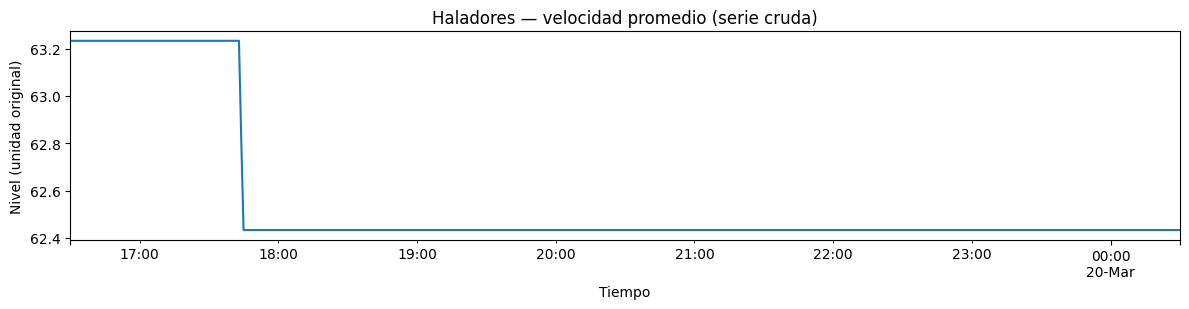

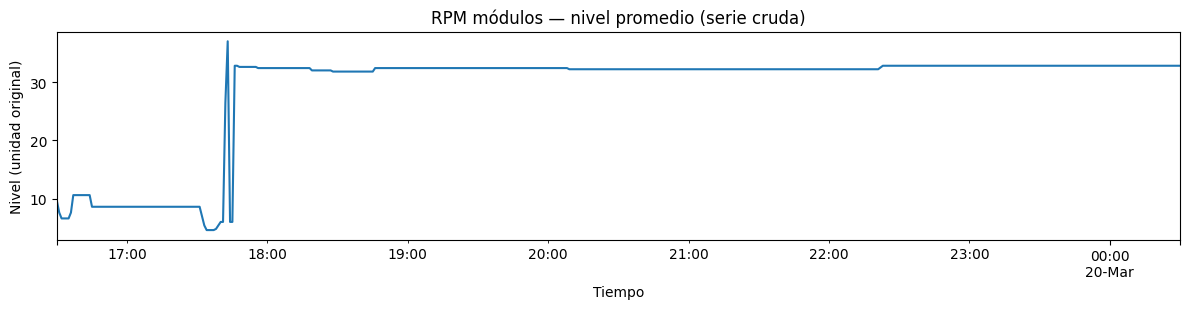

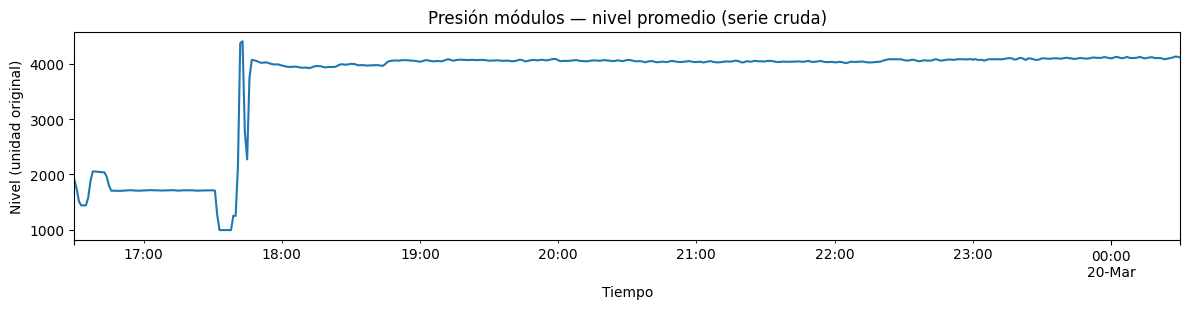

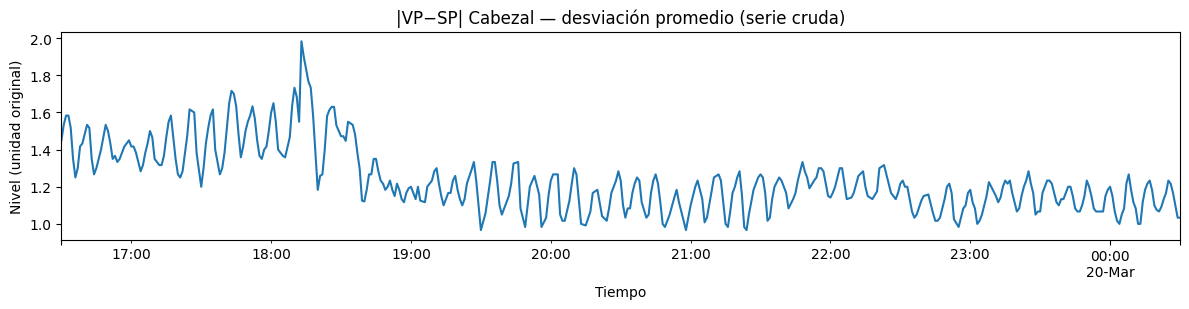


=== Vista de características (primeras 10 filas) ===


,hal_speed_mean_5m,hal_speed_std_5m,hal_pct_zero_5m,rpm_level_mean_5m,rpm_var_t_5m,rpm_absdiff_5m,pres_level_mean_5m,pres_var_t_5m,cbz_dev_mean_5m,cbz_dev_std_5m
Timestamp,,,,,,,,,,
2024-03-19 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-19 16:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-19 16:32:00,63.233333,0.0,0.0,7.933333,1.527525,NaN,1715.533333,197.659944,1.522222,0.067358
2024-03-19 16:33:00,63.233333,0.0,0.0,7.600000,1.414214,1.00,1646.650000,212.193206,1.537500,0.062915
2024-03-19 16:34:00,63.233333,0.0,0.0,7.400000,1.303840,0.75,1605.600000,205.414167,1.533333,0.055277
2024-03-19 16:35:00,63.233333,0.0,0.0,6.800000,0.447214,0.60,1514.080000,128.401760,1.513333,0.096032
2024-03-19 16:36:00,63.233333,0.0,0.0,6.800000,0.447214,0.40,1482.320000,61.247465,1.456667,0.149815
2024-03-19 16:37:00,63.233333,0.0,0.0,7.600000,1.732051,0.80,1557.840000,192.459003,1.400000,0.143372
2024-03-19 16:38:00,63.233333,0.0,0.0,8.400000,2.049390,0.80,1680.920000,276.630678,1.366667,0.104083



=== Umbrales utilizados (tabla) ===


,speed_active_thresh,speed_paro_thresh,rpm_var_lo_p25,rpm_var_hi_p75,hal_var_lo_p25,hal_var_hi_p75,cbz_dev_mid_p50,cbz_dev_hi_p75,pres_high_thresh,pct_zero_hi
0,60.383333,30.191667,0.0,0.0,0.0,0.0,1.143333,1.216667,3704.88,0.8


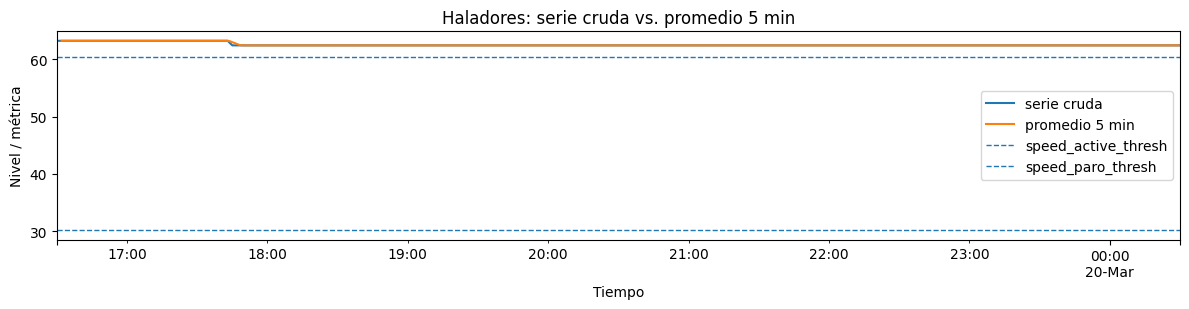

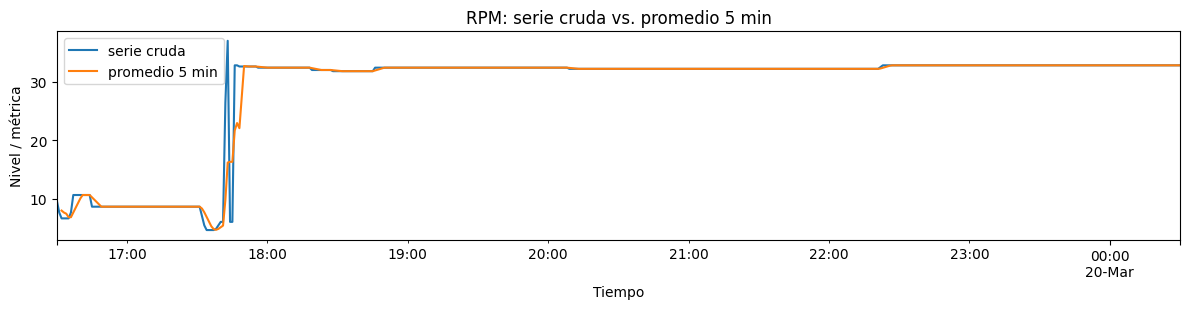

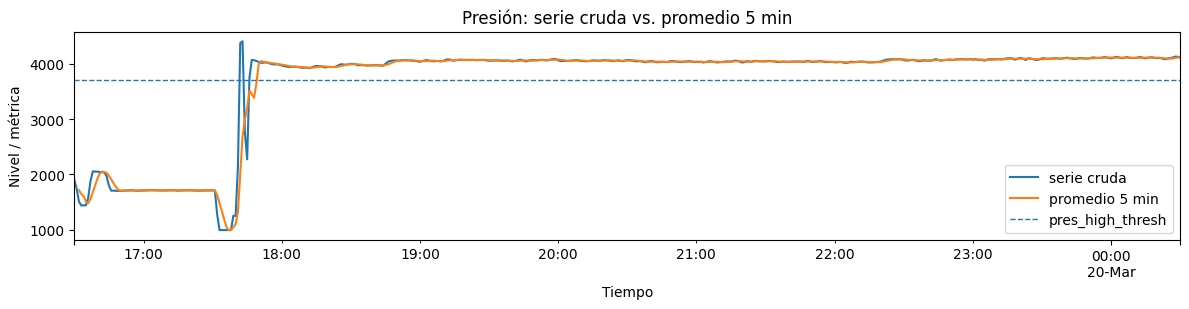

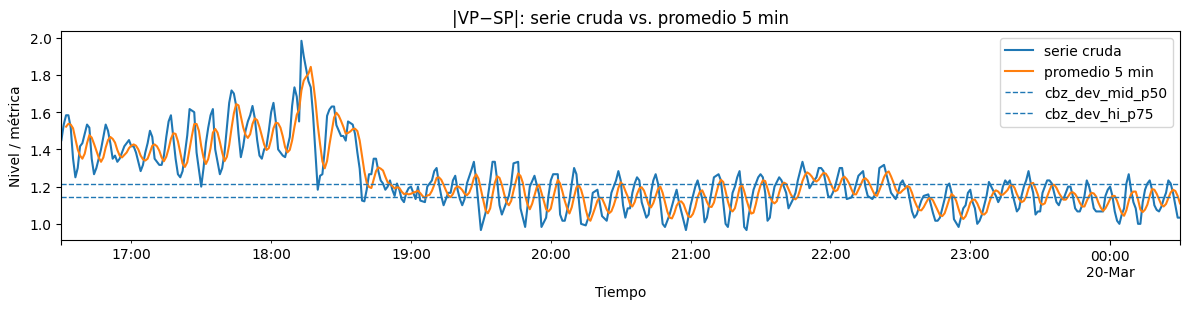


=== Conteo de flags por regla (antes de resolver solapamientos) ===


,conteo
is_paro,0
is_produccion,8716
is_desperdicio,3637



=== Timeline (muestra en la ventana de visualización) ===


,hal_speed_mean_5m,hal_speed_std_5m,hal_pct_zero_5m,rpm_level_mean_5m,rpm_var_t_5m,rpm_absdiff_5m,pres_level_mean_5m,pres_var_t_5m,cbz_dev_mean_5m,cbz_dev_std_5m,estado
Timestamp,,,,,,,,,,,
2024-03-19 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SETUP
2024-03-19 16:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SETUP
2024-03-19 16:32:00,63.233333,0.0,0.0,7.933333,1.527525,NaN,1715.533333,197.659944,1.522222,0.067358,SETUP
2024-03-19 16:33:00,63.233333,0.0,0.0,7.600000,1.414214,1.00,1646.650000,212.193206,1.537500,0.062915,SETUP
2024-03-19 16:34:00,63.233333,0.0,0.0,7.400000,1.303840,0.75,1605.600000,205.414167,1.533333,0.055277,SETUP
2024-03-19 16:35:00,63.233333,0.0,0.0,6.800000,0.447214,0.60,1514.080000,128.401760,1.513333,0.096032,SETUP
2024-03-19 16:36:00,63.233333,0.0,0.0,6.800000,0.447214,0.40,1482.320000,61.247465,1.456667,0.149815,SETUP
2024-03-19 16:37:00,63.233333,0.0,0.0,7.600000,1.732051,0.80,1557.840000,192.459003,1.400000,0.143372,SETUP
2024-03-19 16:38:00,63.233333,0.0,0.0,8.400000,2.049390,0.80,1680.920000,276.630678,1.366667,0.104083,SETUP



=== Distribución final de estados ===


,conteo,porcentaje
estado,,
PRODUCCION,8716,43.19
SETUP,7828,38.79
DESPERDICIO,3637,18.02



=== Matriz de transiciones (estado anterior → estado actual) ===


actual,DESPERDICIO,PRODUCCION,SETUP
anterior,,,
DESPERDICIO,3006,619,12
INICIO,0,0,1
PRODUCCION,615,7384,716
SETUP,16,713,7099


In [ ]:
# =========================================
# # Requisitos: df_1min (index temporal a 1 min), familias_1min y TS_COL (de Bloques 1 y 2.1)
# =========================================
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- 0) Validaciones de entorno ----------
if 'df_1min' not in globals():
    raise RuntimeError("No encuentro 'df_1min'. Ejecuta antes el Bloque 2.1.")
if 'familias_1min' not in globals():
    raise RuntimeError("No encuentro 'familias_1min'. Ejecuta antes el Bloque 2.1.")
if 'TS_COL' not in globals():
    raise RuntimeError("No encuentro 'TS_COL'. Ejecuta antes el Bloque 1.")

# ---------- 1) Familias de variables y series “crudas” clave ----------
HAL = familias_1min.get("haladores_vel", [])
RPM = familias_1min.get("rpm_modulos", [])
PRES = familias_1min.get("presion_modulos", [])
CBZ_SP = familias_1min.get("cabezal_SP", [])
CBZ_VP = familias_1min.get("cabezal_VP", [])

print("=== Familias detectadas (para construir ventanas) ===")
print(f"- Haladores (HAL*_VEL): {len(HAL)} columnas")
print(f"- RPM módulos (MD*_RPM): {len(RPM)} columnas")
print(f"- Presión módulos (MD*_P): {len(PRES)} columnas")
print(f"- Cabezal SP (CBZ_Z*_SP): {len(CBZ_SP)} columnas")
print(f"- Cabezal VP (CBZ_Z*_VP): {len(CBZ_VP)} columnas")

if not HAL:
    raise RuntimeError("No hay columnas de haladores (HAL*_VEL). Son necesarias para el etiquetado de estados.")

# Series crudas base (nivel por minuto)
def _safe_mean(df: pd.DataFrame, cols: list) -> pd.Series:
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(index=df.index, dtype='float64')
    return df[cols].mean(axis=1)

hal_speed = _safe_mean(df_1min, HAL)                       # avance de línea
rpm_level = _safe_mean(df_1min, RPM) if RPM else pd.Series(index=df_1min.index, dtype='float64')
pres_level = _safe_mean(df_1min, PRES) if PRES else pd.Series(index=df_1min.index, dtype='float64')

# |VP - SP| promedio entre zonas del cabezal
if CBZ_SP and CBZ_VP:
    zones = []
    for sp in CBZ_SP:
        vp = sp.replace("_SP", "_VP")
        if vp in df_1min.columns:
            zones.append((vp, sp))
    if zones:
        cbz_dev = pd.concat([(df_1min[vp] - df_1min[sp]).abs() for (vp, sp) in zones], axis=1).mean(axis=1)
    else:
        cbz_dev = pd.Series(index=df_1min.index, dtype='float64')
else:
    cbz_dev = pd.Series(index=df_1min.index, dtype='float64')

# Rango temporal de trabajo
print("\n=== Rango temporal en df_1min ===")
print(df_1min.index.min(), "→", df_1min.index.max())
print(f"Total de filas (minutos): {len(df_1min)}")

# ---------- 2) Selección de una ventana de visualización (para gráficas) ----------
# Para no saturar, graficamos por defecto ~8 horas continuas desde el inicio.
PLOT_HOURS = 8
start_ts = df_1min.index.min()
end_ts = start_ts + pd.Timedelta(hours=PLOT_HOURS)
if end_ts > df_1min.index.max():
    end_ts = df_1min.index.max()
plot_slice = slice(start_ts, end_ts)
print(f"\nVentana de visualización sugerida: {start_ts} → {end_ts} (~{PLOT_HOURS} h)\n"
      f"(Edita PLOT_HOURS si quieres ver un tramo mayor.)")

# ---------- 3) Gráficas de series crudas (nivel) ----------
# Nota: se usa Matplotlib simple y una figura por gráfico (evita warnings/deprecaciones).
def _quick_plot(series: pd.Series, title: str):
    plt.figure(figsize=(12, 3.2))
    series.loc[plot_slice].plot()
    plt.title(title)
    plt.xlabel("Tiempo")
    plt.ylabel("Nivel (unidad original)")
    plt.tight_layout()
    plt.show()

_quick_plot(hal_speed, "Haladores — velocidad promedio (serie cruda)")
if not rpm_level.empty:
    _quick_plot(rpm_level, "RPM módulos — nivel promedio (serie cruda)")
if not pres_level.empty:
    _quick_plot(pres_level, "Presión módulos — nivel promedio (serie cruda)")
if not cbz_dev.empty:
    _quick_plot(cbz_dev, "|VP−SP| Cabezal — desviación promedio (serie cruda)")

# ---------- 4) Construcción de características en ventanas (5 min, paso 1 min) ----------
# Una "ventana" de 5 minutos suaviza y resume el comportamiento reciente para cada instante.
WINDOW = '5min'
MINP = 3  # se requieren al menos 3 datos dentro de la ventana

def _roll_mean(s): return s.rolling(window=WINDOW, min_periods=MINP).mean()
def _roll_std(s):  return s.rolling(window=WINDOW, min_periods=MINP).std()

# Variabilidad temporal agregada: |Δ| minuto a minuto promedio entre columnas
def _rolling_mean_absdiff(df: pd.DataFrame, cols: list) -> pd.Series:
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(index=df.index, dtype='float64')
    absdiff = df[cols].diff().abs().mean(axis=1)
    return absdiff.rolling(window=WINDOW, min_periods=MINP).mean()

def _percent_zero_haladores(df: pd.DataFrame, hal_cols: list) -> pd.Series:
    hal_cols = [c for c in hal_cols if c in df.columns]
    zeros = df[hal_cols].eq(0).astype('float64')
    z_time = zeros.rolling(window=WINDOW, min_periods=MINP).mean()
    return z_time.mean(axis=1)  # promedio entre haladores

features = pd.DataFrame(index=df_1min.index)
features["hal_speed_mean_5m"] = _roll_mean(hal_speed)
features["hal_speed_std_5m"]  = _roll_std(hal_speed)
features["hal_pct_zero_5m"]   = _percent_zero_haladores(df_1min, HAL)

if not rpm_level.empty:
    features["rpm_level_mean_5m"] = _roll_mean(rpm_level)
    features["rpm_var_t_5m"]      = _roll_std(rpm_level)
    features["rpm_absdiff_5m"]    = _rolling_mean_absdiff(df_1min, RPM)

if not pres_level.empty:
    features["pres_level_mean_5m"] = _roll_mean(pres_level)
    features["pres_var_t_5m"]      = _roll_std(pres_level)

if not cbz_dev.empty:
    features["cbz_dev_mean_5m"] = _roll_mean(cbz_dev)
    features["cbz_dev_std_5m"]  = _roll_std(cbz_dev)

print("\n=== Vista de características (primeras 10 filas) ===")
display(features.head(10))

# ---------- 5) Umbrales automáticos (explicados) ----------
def _robust_q(s: pd.Series, q: float, fallback=np.nan):
    try:
        v = s.quantile(q)
        if pd.isna(v): return fallback
        return float(v)
    except Exception:
        return fallback

pos_hal = hal_speed[hal_speed > 0]
speed_active_thresh = _robust_q(pos_hal, 0.10, fallback=0.0)   # p10 de haladores > 0 → "línea activa"
speed_paro_thresh   = 0.5 * speed_active_thresh                # 50% de lo activo → "paro contundente"

rpm_var_hi = _robust_q(features["rpm_var_t_5m"].dropna(), 0.75, fallback=np.nan) if "rpm_var_t_5m" in features else np.nan
rpm_var_lo = _robust_q(features["rpm_var_t_5m"].dropna(), 0.25, fallback=np.nan) if "rpm_var_t_5m" in features else np.nan
hal_var_hi = _robust_q(features["hal_speed_std_5m"].dropna(), 0.75, fallback=np.nan)
hal_var_lo = _robust_q(features["hal_speed_std_5m"].dropna(), 0.25, fallback=np.nan)
dev_hi     = _robust_q(features["cbz_dev_mean_5m"].dropna(), 0.75, fallback=np.nan) if "cbz_dev_mean_5m" in features else np.nan
dev_mid    = _robust_q(features["cbz_dev_mean_5m"].dropna(), 0.50, fallback=np.nan) if "cbz_dev_mean_5m" in features else np.nan

if "pres_level_mean_5m" in features:
    pres_med     = _robust_q(features["pres_level_mean_5m"].dropna(), 0.50, fallback=np.nan)
    pres_high_th = np.nanmax([300.0, pres_med])
else:
    pres_high_th = np.nan

pct_zero_hi = 0.8  # 80% de ceros dentro de la ventana

thresholds_df = pd.DataFrame.from_dict({
    "speed_active_thresh": [speed_active_thresh],
    "speed_paro_thresh":   [speed_paro_thresh],
    "rpm_var_lo_p25":      [rpm_var_lo],
    "rpm_var_hi_p75":      [rpm_var_hi],
    "hal_var_lo_p25":      [hal_var_lo],
    "hal_var_hi_p75":      [hal_var_hi],
    "cbz_dev_mid_p50":     [dev_mid],
    "cbz_dev_hi_p75":      [dev_hi],
    "pres_high_thresh":    [pres_high_th],
    "pct_zero_hi":         [pct_zero_hi],
})
print("\n=== Umbrales utilizados (tabla) ===")
display(thresholds_df)

# ---------- 6) Gráficas intermedias con ventanas y umbrales ----------
def _plot_with_window_and_lines(raw_series, win_series, title, hlines: dict):
    plt.figure(figsize=(12, 3.2))
    raw_series.loc[plot_slice].plot(label="serie cruda")
    if win_series is not None:
        win_series.loc[plot_slice].plot(label="promedio 5 min")
    for name, y in (hlines or {}).items():
        if pd.notna(y):
            plt.axhline(y, linestyle="--", linewidth=1.0, label=name)
    plt.title(title)
    plt.xlabel("Tiempo"); plt.ylabel("Nivel / métrica")
    plt.legend()
    plt.tight_layout()
    plt.show()

_plot_with_window_and_lines(
    hal_speed, features["hal_speed_mean_5m"],
    "Haladores: serie cruda vs. promedio 5 min",
    {"speed_active_thresh": speed_active_thresh, "speed_paro_thresh": speed_paro_thresh}
)

if "rpm_level_mean_5m" in features:
    _plot_with_window_and_lines(
        rpm_level, features["rpm_level_mean_5m"],
        "RPM: serie cruda vs. promedio 5 min",
        {}
    )
if "pres_level_mean_5m" in features:
    _plot_with_window_and_lines(
        pres_level, features["pres_level_mean_5m"],
        "Presión: serie cruda vs. promedio 5 min",
        {"pres_high_thresh": pres_high_th}
    )
if "cbz_dev_mean_5m" in features:
    _plot_with_window_and_lines(
        cbz_dev, features["cbz_dev_mean_5m"],
        "|VP−SP|: serie cruda vs. promedio 5 min",
        {"cbz_dev_mid_p50": dev_mid, "cbz_dev_hi_p75": dev_hi}
    )

# ---------- 7) Reglas de estado (paso a paso) ----------
is_paro = (
    (features["hal_speed_mean_5m"] <= speed_paro_thresh) |
    (features["hal_pct_zero_5m"]   >= pct_zero_hi)
)

is_produccion = (
    (features["hal_speed_mean_5m"] >= speed_active_thresh) &
    ((pd.isna(rpm_var_lo) | (features.get("rpm_var_t_5m", pd.Series(index=features.index)) <= rpm_var_lo)) &
     (pd.isna(hal_var_lo) | (features["hal_speed_std_5m"] <= hal_var_lo)) &
     (pd.isna(dev_mid)    | (features.get("cbz_dev_mean_5m", pd.Series(index=features.index)) <= dev_mid))) &
    (pd.isna(pres_high_th) | (features.get("pres_level_mean_5m", pd.Series(index=features.index)) >= 0))
) & (~is_paro)

is_desperdicio = (
    (features["hal_speed_mean_5m"] >= speed_active_thresh) &
    (
        ((not pd.isna(rpm_var_hi)) & (features.get("rpm_var_t_5m", pd.Series(index=features.index)) >= rpm_var_hi)) |
        ((not pd.isna(hal_var_hi)) & (features["hal_speed_std_5m"] >= hal_var_hi)) |
        ((not pd.isna(dev_hi))     & (features.get("cbz_dev_mean_5m", pd.Series(index=features.index)) >= dev_hi))
    ) &
    (pd.isna(pres_high_th) | (features.get("pres_level_mean_5m", pd.Series(index=features.index)) >= pres_high_th))
) & (~is_paro) & (~is_produccion)

labels = pd.Series(index=features.index, dtype='object')
labels.loc[is_paro]       = "PARO"
labels.loc[is_produccion] = "PRODUCCION"
labels.loc[is_desperdicio]= "DESPERDICIO"
labels.fillna("SETUP", inplace=True)

# Conteo de flags (antes de resolución final)
flags_report = pd.DataFrame({
    "is_paro": is_paro.sum(),
    "is_produccion": is_produccion.sum(),
    "is_desperdicio": is_desperdicio.sum()
}, index=["conteo"]).T
print("\n=== Conteo de flags por regla (antes de resolver solapamientos) ===")
display(flags_report)

# ---------- 8) Timeline de estados y salidas finales ----------
timeline = features.copy()
timeline["estado"] = labels

# Muestra del timeline (tramo de visualización)
print("\n=== Timeline (muestra en la ventana de visualización) ===")
display(timeline.loc[plot_slice].head(15))

# Distribución final de estados
counts = timeline["estado"].value_counts(dropna=False).sort_values(ascending=False)
perc = (100 * counts / counts.sum()).round(2)
dist_estados = pd.DataFrame({"conteo": counts, "porcentaje": perc})
print("\n=== Distribución final de estados ===")
display(dist_estados)

# Transiciones entre estados (útil para entender dinámica)
trans = pd.crosstab(
    timeline["estado"].shift(1).fillna("INICIO"),
    timeline["estado"], rownames=["anterior"], colnames=["actual"]
)
print("\n=== Matriz de transiciones (estado anterior → estado actual) ===")
display(trans)

# ---------- 9) (Opcional) Persistencia de artefactos ----------
# dist_estados.to_csv("dist_estados.csv")
# timeline.to_csv("timeline_estados_5m.csv")                 # grande
# thresholds_df.to_csv("umbrales_utilizados.csv", index=False)
# flags_report.to_csv("flags_por_regla.csv")


# **3. Cálculo de disponibilidad, rendimiento y calidad**

## **3.1. Métricas por días y turnos**

=== Indicadores por DÍA (primeras filas) ===


,fecha,disponibilidad,rendimiento,buenos,activos,calidad,DESPERDICIO,PRODUCCION,SETUP
0,2024-03-19,1.0,0.986073,125.0,370.0,0.337838,245,125,80
1,2024-03-20,1.0,0.980358,980.0,1440.0,0.680556,460,980,0
2,2024-03-21,1.0,0.975834,727.0,1440.0,0.504861,713,727,0
3,2024-03-22,1.0,0.976635,321.0,1102.0,0.291289,781,321,338
4,2024-03-23,1.0,0.977689,737.0,1177.0,0.626168,440,737,263



=== Indicadores por DÍA y TURNO (primeras filas) ===


,fecha,turno,disponibilidad,rendimiento,buenos,activos,calidad,DESPERDICIO,PRODUCCION,SETUP
0,2024-03-19,Turno B (14-22),1.0,0.986840,76.0,250.0,0.304000,174,76,80
1,2024-03-19,Turno C (22-06),1.0,0.983977,49.0,120.0,0.408333,71,49,0
2,2024-03-20,Turno A (06-14),1.0,0.983298,383.0,480.0,0.797917,97,383,0
3,2024-03-20,Turno B (14-22),1.0,0.975834,356.0,480.0,0.741667,124,356,0
4,2024-03-20,Turno C (22-06),1.0,0.981941,241.0,480.0,0.502083,239,241,0


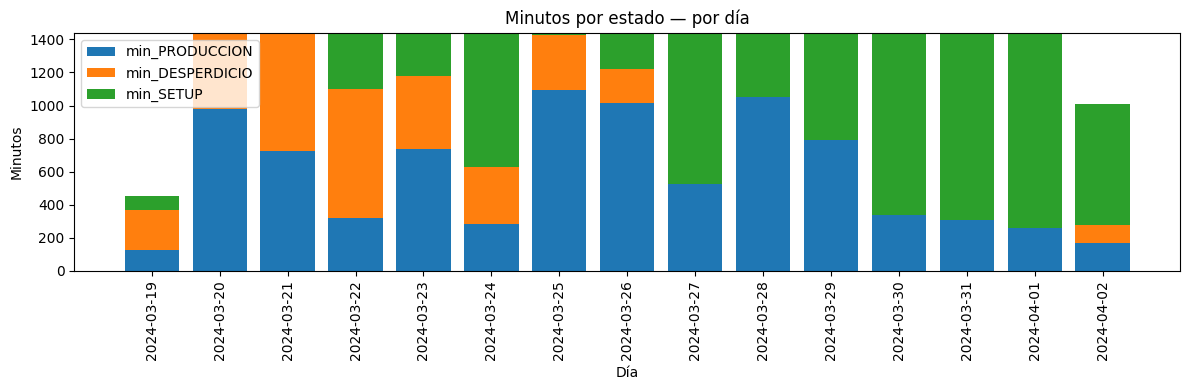

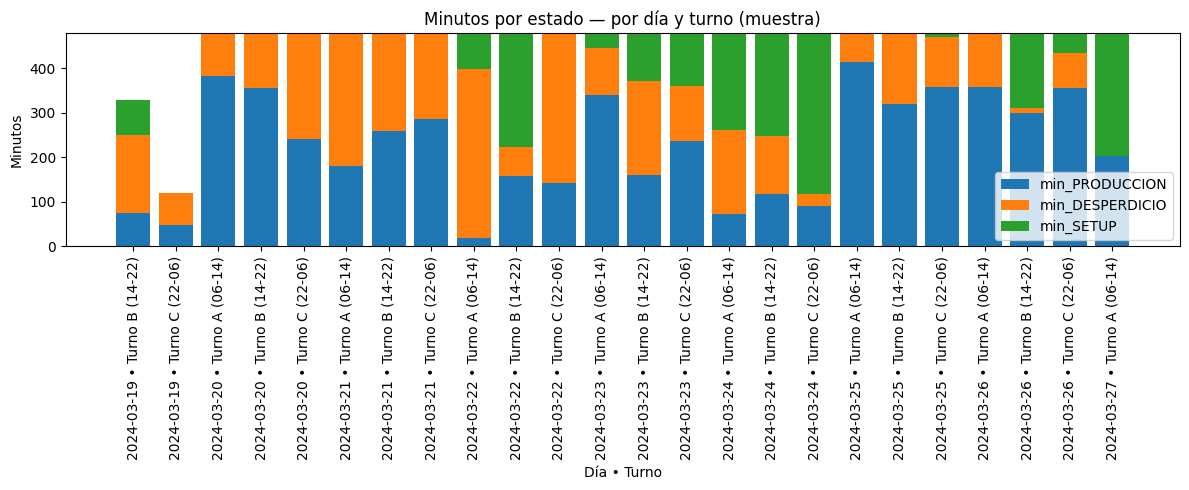

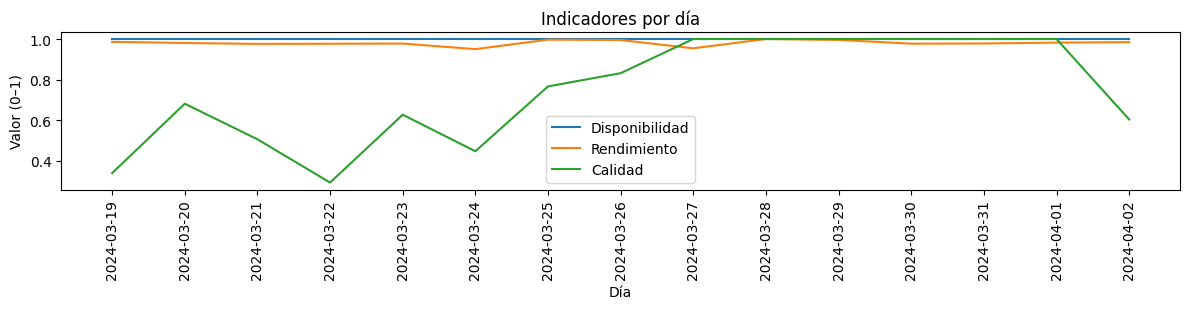

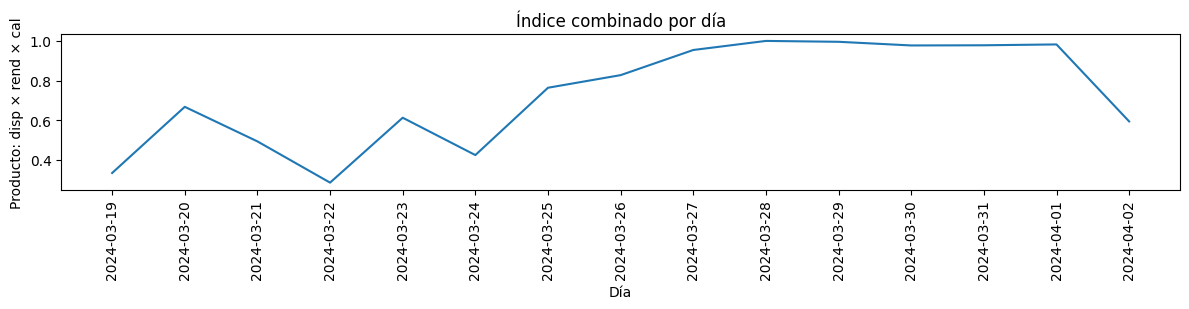

In [ ]:
# =========================================
# BLOQUE 3A — Métricas por turnos
# Requisitos: timeline (con 'estado', 'hal_speed_mean_5m', 'hal_speed_std_5m'), df_1min, TS_COL
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# --------- 0) Reconstrucción segura de métricas por minuto (si no existen) ---------
need_cols = {"estado", "hal_speed_mean_5m", "hal_speed_std_5m"}
if 'timeline' not in globals() or not need_cols.issubset(set(timeline.columns)):
    raise RuntimeError("Faltan 'timeline' o columnas básicas del Bloque 2B.")

# Recalcula velocidad nominal de forma robusta (evita avisos y divisiones por cero)
prod_mask = timeline["estado"].eq("PRODUCCION")
std_series = timeline["hal_speed_std_5m"].dropna()
var_p25 = std_series.quantile(0.25) if len(std_series)>0 else np.nan

if np.isnan(var_p25):
    base_for_nominal = timeline["hal_speed_mean_5m"].dropna()
else:
    base_for_nominal = timeline.loc[
        prod_mask & (timeline["hal_speed_std_5m"] <= var_p25),
        "hal_speed_mean_5m"
    ].dropna()

if len(base_for_nominal) == 0:
    base_for_nominal = timeline.loc[timeline["hal_speed_mean_5m"] > 0, "hal_speed_mean_5m"].dropna()
if len(base_for_nominal) == 0:
    raise RuntimeError("No hay datos de velocidad suficientes para estimar un valor nominal.")

velocidad_nominal = float(base_for_nominal.quantile(0.90))
if velocidad_nominal <= 0:
    positives = timeline.loc[timeline["hal_speed_mean_5m"] > 0, "hal_speed_mean_5m"]
    velocidad_nominal = float(max(positives.mean(), 1e-6))

# Crea 'out' con métricas por minuto
out = timeline.copy()
out["disp_min"] = (~out["estado"].eq("PARO")).astype("float64")
out["rend_min"] = (out["hal_speed_mean_5m"] / velocidad_nominal).clip(lower=0, upper=1)
out["activo_min"] = out["estado"].isin(["PRODUCCION", "DESPERDICIO"]).astype("float64")
out["calidad_bueno_min"] = (out["estado"].eq("PRODUCCION")).astype("float64")

# --------- 1) Turnos parametrizables (fácil de cambiar) ---------
# Definir aquí  turnos (pares [hora_inicio, hora_fin] en formato 24h, fin exclusivo).
# Nota: si un turno cruza medianoche, ponerlo con el fin más pequeño (ej. 22–06).
TURNOS = [
    ("Turno A (06-14)", 6, 14),
    ("Turno B (14-22)", 14, 22),
    ("Turno C (22-06)", 22, 6)
]

def asignar_turno(ts):
    h = ts.hour
    for nombre, h_ini, h_fin in TURNOS:
        if h_ini < h_fin:
            if h_ini <= h < h_fin:
                return nombre
        else:
            # Cruza medianoche
            if h >= h_ini or h < h_fin:
                return nombre
    return "Turno (?)"

out["fecha"] = out.index.date
out["turno"] = [asignar_turno(ts) for ts in out.index]

# --------- 2) Agregados SIN apply() para evitar avisos ---------
# Por día: medias y sumas
agg_day = out.groupby("fecha", sort=True).agg(
    disp=("disp_min", "mean"),
    rend=("rend_min", "mean"),
    buenos=("calidad_bueno_min", "sum"),
    activos=("activo_min", "sum")
)

# Calidad diaria (buenos / activos)
agg_day["calidad"] = np.where(agg_day["activos"]>0, agg_day["buenos"]/agg_day["activos"], np.nan)
agg_day.rename(columns={"disp":"disponibilidad", "rend":"rendimiento"}, inplace=True)

# Minutos por estado (crosstab)
min_por_estado_day = pd.crosstab(out["fecha"], out["estado"]).reindex(agg_day.index, fill_value=0)

por_dia = pd.concat([agg_day, min_por_estado_day], axis=1).reset_index()

print("=== Indicadores por DÍA (primeras filas) ===")
display(por_dia.head())

# Por día y turno
agg_dt = out.groupby(["fecha", "turno"], sort=True).agg(
    disp=("disp_min", "mean"),
    rend=("rend_min", "mean"),
    buenos=("calidad_bueno_min", "sum"),
    activos=("activo_min", "sum")
)
agg_dt["calidad"] = np.where(agg_dt["activos"]>0, agg_dt["buenos"]/agg_dt["activos"], np.nan)
agg_dt.rename(columns={"disp":"disponibilidad", "rend":"rendimiento"}, inplace=True)

min_por_estado_dt = pd.crosstab([out["fecha"], out["turno"]], out["estado"]).reindex(agg_dt.index, fill_value=0)

por_dia_turno = pd.concat([agg_dt, min_por_estado_dt], axis=1).reset_index()

print("\n=== Indicadores por DÍA y TURNO (primeras filas) ===")
display(por_dia_turno.head())

# --------- 3) Gráficas con ejes legibles (fechas rotadas) ---------
ROT = 90  # rotación de las etiquetas del eje X

# (a) Minutos por estado — por día
est_cols = [c for c in ["PARO","PRODUCCION","DESPERDICIO","SETUP"] if c in por_dia.columns]
x = por_dia["fecha"].astype(str).to_list()
plt.figure(figsize=(12, 4))
bottom = np.zeros(len(por_dia))
for col in est_cols:
    vals = por_dia[col].to_numpy()
    plt.bar(x, vals, bottom=bottom, label=f"min_{col}")
    bottom = bottom + vals
plt.title("Minutos por estado — por día")
plt.xlabel("Día"); plt.ylabel("Minutos")
plt.xticks(rotation=ROT)
plt.legend()
plt.tight_layout(); plt.show()

# (b) Minutos por estado — por día y turno (muestra hasta 24 barras)
subset = por_dia_turno.head(24).copy()
x2 = (subset["fecha"].astype(str) + " • " + subset["turno"]).to_list()
plt.figure(figsize=(12, 5))
bottom = np.zeros(len(subset))
for col in est_cols:
    vals = subset[col].to_numpy()
    plt.bar(x2, vals, bottom=bottom, label=f"min_{col}")
    bottom = bottom + vals
plt.title("Minutos por estado — por día y turno (muestra)")
plt.xlabel("Día • Turno"); plt.ylabel("Minutos")
plt.xticks(rotation=ROT)
plt.legend()
plt.tight_layout(); plt.show()

# (c) Indicadores por día
plt.figure(figsize=(12, 3.2))
plt.plot(por_dia["fecha"].astype(str), por_dia["disponibilidad"], label="Disponibilidad")
plt.plot(por_dia["fecha"].astype(str), por_dia["rendimiento"],   label="Rendimiento")
plt.plot(por_dia["fecha"].astype(str), por_dia["calidad"],       label="Calidad")
plt.title("Indicadores por día")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT)
plt.legend(); plt.tight_layout(); plt.show()

# (d) Índice combinado por día (producto simple)
por_dia["indice_combinado"] = por_dia["disponibilidad"] * por_dia["rendimiento"] * por_dia["calidad"]
plt.figure(figsize=(12, 3.2))
plt.plot(por_dia["fecha"].astype(str), por_dia["indice_combinado"])
plt.title("Índice combinado por día")
plt.xlabel("Día"); plt.ylabel("Producto: disp × rend × cal"); plt.xticks(rotation=ROT)
plt.tight_layout(); plt.show()

## **3.2. Cálculos de desperdicio**

In [ ]:
# =========================================
# BLOQUE 3B — Ajuste “DESPERDICIO” + evidencia
# Requisitos: timeline (features 5 min) y 'out' creado en 3A
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

if 'timeline' not in globals() or 'out' not in globals():
    raise RuntimeError("Ejecuta primero los Bloques 2B y 3A.")

# Recalcula umbrales a partir de las features (5 min)
def _q(s, p, fallback=np.nan):
    s = s.dropna()
    return float(s.quantile(p)) if len(s) else fallback

speed_active_thresh = _q(timeline["hal_speed_mean_5m"][timeline["hal_speed_mean_5m"]>0], 0.10, 0.0)
hal_var_hi = _q(timeline["hal_speed_std_5m"], 0.80)  # más estricto (p80)
rpm_var_hi = _q(timeline["rpm_var_t_5m"],    0.80) if "rpm_var_t_5m" in timeline else np.nan
dev_hi     = _q(timeline["cbz_dev_mean_5m"], 0.80) if "cbz_dev_mean_5m" in timeline else np.nan
pres_med   = _q(timeline["pres_level_mean_5m"], 0.50) if "pres_level_mean_5m" in timeline else np.nan
pres_high_th = np.nanmax([300.0, pres_med]) if not np.isnan(pres_med) else np.nan

# Condiciones base para DESPERDICIO_ESTRICTO
is_active = timeline["hal_speed_mean_5m"] >= speed_active_thresh
c_hal_instab = timeline["hal_speed_std_5m"] >= hal_var_hi
c_rpm_instab = timeline["rpm_var_t_5m"]    >= rpm_var_hi if "rpm_var_t_5m" in timeline else pd.Series(False, index=timeline.index)
c_dev_alta   = timeline["cbz_dev_mean_5m"] >= dev_hi     if "cbz_dev_mean_5m" in timeline else pd.Series(False, index=timeline.index)
c_pres_alta  = timeline["pres_level_mean_5m"] >= pres_high_th if "pres_level_mean_5m" in timeline and not np.isnan(pres_high_th) else pd.Series(True, index=timeline.index)

# Reglas: activo Y (inestabilidad en haladores O rpm O desviación alta) Y presión alta (si existe)
desp_strict_mask = (is_active & (c_hal_instab | c_rpm_instab | c_dev_alta) & c_pres_alta)

# Evidencias (conteos)
evid = pd.DataFrame({
    "is_active": is_active.sum(),
    "hal_instab": c_hal_instab.sum(),
    "rpm_instab": c_rpm_instab.sum() if isinstance(c_rpm_instab, pd.Series) else 0,
    "dev_alta": c_dev_alta.sum() if isinstance(c_dev_alta, pd.Series) else 0,
    "pres_alta": c_pres_alta.sum(),
    "desp_strict": desp_strict_mask.sum()
}, index=["conteo"]).T

print("=== Evidencias por condición (conteo de minutos que cumplen) ===")
display(evid)

# Nuevo estado (solo ajusta DESPERDICIO→SETUP cuando no cumple el estricto)
estado_v2 = out["estado"].copy()
fix_idx = (out["estado"].eq("DESPERDICIO") & (~desp_strict_mask))
estado_v2.loc[fix_idx] = "SETUP"

print("\nMinutos ajustados de DESPERDICIO→SETUP:", int(fix_idx.sum()))
dist_v1 = out["estado"].value_counts().rename("original")
dist_v2 = estado_v2.value_counts().rename("ajustado")
dist_cmp = pd.concat([dist_v1, dist_v2], axis=1).fillna(0).astype(int)
print("\n=== Comparación de distribución de estados (original vs ajustado) ===")
display(dist_cmp)

# Si queremos usar el estado ajustado en los indicadores, sobreescribir en 'out':
# out["estado"] = estado_v2
# (y se vuelve a correr el bloque 3.1 para ver cómo cambian los agregados)


=== Evidencias por condición (conteo de minutos que cumplen) ===


,conteo
is_active,18436
hal_instab,20179
rpm_instab,20179
dev_alta,4039
pres_alta,10090
desp_strict,8452



Minutos ajustados de DESPERDICIO→SETUP: 0

=== Comparación de distribución de estados (original vs ajustado) ===


,original,ajustado
estado,,
PRODUCCION,8716,8716
SETUP,7828,7828
DESPERDICIO,3637,3637


## **3.3. Clustering (aprendizaje automático) y mapeo a estados**

Aquí aplicamos aprendizaje automático: agrupamos automáticamente los minutos en cuatro clústeres usando K-Means sobre las características en ventana. Luego, mapeamos cada clúster al estado (PARO/PRODUCCION/DESPERDICIO/SETUP) por mayoría respecto a las etiquetas por reglas (originales o ajustadas). Se incluye una proyección PCA para visualizar.

=== Resumen por k (métricas para decidir) ===


,clusters_distintos,silhouette,inercia,min_prop_cluster
k,,,,
2,2,0.859107,129713.088393,0.006988
3,3,0.305190,102003.047183,0.007037
4,4,0.333454,86428.355986,0.006988



Selección final de k: 4

=== Tamaño de cada clúster ===


,conteo
0,13253
1,141
2,6177
3,607



=== Medianas de características por clúster ===


,hal_speed_mean_5m,hal_speed_std_5m,rpm_level_mean_5m,rpm_var_t_5m,rpm_absdiff_5m,pres_level_mean_5m,pres_var_t_5m,cbz_dev_mean_5m,cbz_dev_std_5m
cluster,,,,,,,,,
0,62.683333,0.0,25.20,0.000000,0.00,3395.00,6.651316,1.139167,0.098601
1,62.050000,0.0,17.32,9.928142,4.76,2512.72,1154.076748,1.213333,0.089830
2,61.916667,0.0,33.60,0.000000,0.00,4235.92,7.805639,1.152500,0.087995
3,62.050000,0.0,5.20,0.000000,0.00,1119.20,1.923538,1.210000,0.098178



=== Tabla clúster vs. estado (reglas) ===


estado,DESPERDICIO,PRODUCCION,SETUP
cluster,,,
0,1214,6412,5627
1,4,0,137
2,2419,2122,1636
3,0,182,425



=== Matriz de confusión (regla vs. clúster-mapeado) ===


estado_cluster,DESPERDICIO,PRODUCCION,SETUP
estado_regla,,,
DESPERDICIO,2419,1214,4
PRODUCCION,2122,6412,182
SETUP,1636,5627,562


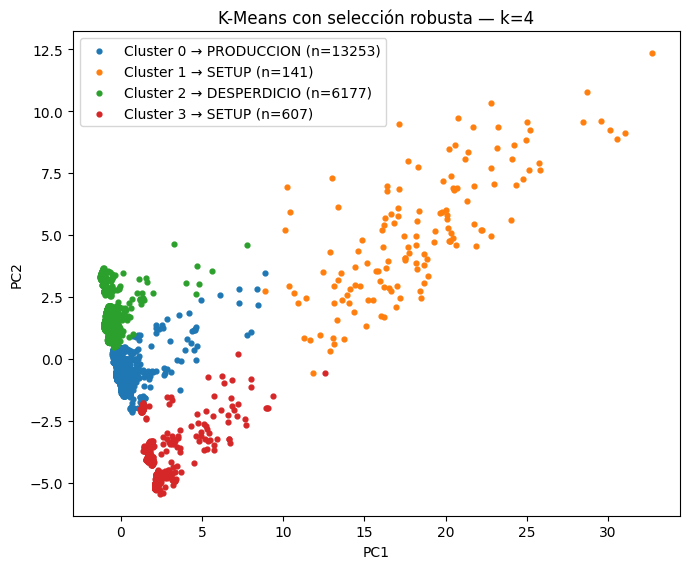

In [ ]:
# =========================================
# BLOQUE 3.3. — Clustering con selección robusta
# Requisitos: 'features' (ventanas 5 min), 'out' (con columna 'estado'), 'timeline'
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import isfinite

# -------- 0) Validaciones y columnas de trabajo --------
if 'features' not in globals() or 'out' not in globals():
    raise RuntimeError("Faltan 'features' u 'out'. Ejecuta Bloques 2B y 3A primero.")

candidate_cols = [
    "hal_speed_mean_5m","hal_speed_std_5m",
    "rpm_level_mean_5m","rpm_var_t_5m","rpm_absdiff_5m",
    "pres_level_mean_5m","pres_var_t_5m",
    "cbz_dev_mean_5m","cbz_dev_std_5m"
]
use_cols = [c for c in candidate_cols if c in features.columns]
if len(use_cols) < 2:
    raise RuntimeError("No hay suficientes características para clustering (se requieren ≥2).")

Xfull = features[use_cols].select_dtypes(include=[np.number]).copy()
mask_rows = Xfull.dropna().index
X = Xfull.loc[mask_rows]
y_rule = out.loc[mask_rows, "estado"]  # etiquetas por reglas

n_samples = len(X)
if n_samples < 5:
    print("⚠️ Muy pocos datos completos para un clustering estable (n<5). Se omite clustering.")
    display(pd.DataFrame({"filas_completas_para_clustering":[n_samples]}))
else:
    # -------- 1) Escalado --------
    scaler = StandardScaler()
    Xscaled = scaler.fit_transform(X)

    # -------- 2) Barrido de k y métricas --------
    # Preferimos k altos, pero evaluamos todos para decidir con datos.
    k_list = [2, 3, 4]
    k_list = [k for k in k_list if k <= n_samples]  # k no puede exceder muestras

    rows = []
    models = {}
    labels_dict = {}

    for k in k_list:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        lab = km.fit_predict(Xscaled)
        uniq = np.unique(lab)
        inertia = float(km.inertia_) if hasattr(km, "inertia_") else np.nan

        # métricas
        sil = np.nan
        if len(uniq) > 1 and n_samples > k:
            try:
                sil = float(silhouette_score(Xscaled, lab))
            except Exception:
                sil = np.nan

        # tamaños relativos
        vc = pd.Series(lab).value_counts(normalize=True).sort_index()
        min_prop = float(vc.min()) if len(vc) else np.nan

        rows.append({
            "k": k,
            "clusters_distintos": int(len(uniq)),
            "silhouette": sil,
            "inercia": inertia,
            "min_prop_cluster": min_prop
        })
        models[k] = km
        labels_dict[k] = lab

    k_report = pd.DataFrame(rows).set_index("k").sort_index()
    print("=== Resumen por k (métricas para decidir) ===")
    display(k_report)

    # -------- 3) Selección robusta con preferencia por k altos --------
    # Reglas sencillas y claras:
    # (a) Solo consideramos k con todos los clústeres presentes (clusters_distintos == k)
    # (b) Exigimos que ningún clúster sea diminuto: min_prop_cluster >= 0.05 (5%)
    # (c) Preferimos el k con mayor silhouette.
    # (d) Si hay varios cerca del mejor silhouette, nos quedamos con el MAYOR k dentro de una tolerancia.
    # (e) Si no se puede calcular silhouette, elegimos el MAYOR k que cumpla (a) y (b).
    valid = k_report[
        (k_report["clusters_distintos"] == k_report.index) &
        (k_report["min_prop_cluster"] >= 0.05)
    ].copy()

    chosen_k = None
    if not valid.empty:
        # Si hay silhouette disponible en alguno:
        if valid["silhouette"].notna().any():
            best_sil = valid["silhouette"].max()
            # tolerancia: acepta cualquier k cuya silhouette esté a no más de 0.02 del máximo
            tol = 0.02
            near = valid[valid["silhouette"] >= (best_sil - tol)]
            # de los "near", elegimos el mayor k (preferencia por k altos)
            chosen_k = int(near.index.max())
        else:
            # Sin silhouette: elige el mayor k válido
            chosen_k = int(valid.index.max())

    # Si nada pasó los filtros (pocos datos o distribución muy desigual), relajamos min_prop a 0.02
    if chosen_k is None:
        relaxed = k_report[
            (k_report["clusters_distintos"] == k_report.index) &
            (k_report["min_prop_cluster"] >= 0.02)
        ]
        if not relaxed.empty:
            if relaxed["silhouette"].notna().any():
                best_sil = relaxed["silhouette"].max()
                tol = 0.02
                near = relaxed[relaxed["silhouette"] >= (best_sil - tol)]
                chosen_k = int(near.index.max())
            else:
                chosen_k = int(relaxed.index.max())

    # Último recurso: si aún no hay elección, usa el mayor k que al menos tenga ≥2 clústeres
    if chosen_k is None:
        fallback = k_report[k_report["clusters_distintos"] >= 2]
        chosen_k = int(fallback.index.max()) if not fallback.empty else int(k_list[0])

    print(f"\nSelección final de k: {chosen_k}")

    # -------- 4) Etiquetas finales, PCA y leyenda --------
    labels_km = labels_dict[chosen_k]
    km = models[chosen_k]

    # Proyección PCA 2D (si hay suficientes filas)
    can_pca = n_samples >= 2
    if can_pca:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(Xscaled)
    else:
        X2 = None

    # Tabla de tamaño por clúster y medianas
    cluster_counts = pd.Series(labels_km).value_counts().sort_index()
    print("\n=== Tamaño de cada clúster ===")
    display(cluster_counts.rename("conteo").to_frame())

    cluster_medians = pd.DataFrame(X, columns=use_cols).assign(cluster=labels_km).groupby("cluster").median()
    print("\n=== Medianas de características por clúster ===")
    display(cluster_medians)

    # Mapeo clúster → estado por mayoría vs. reglas
    ct = pd.crosstab(pd.Series(labels_km, index=X.index, name="cluster"), y_rule, dropna=False)
    print("\n=== Tabla clúster vs. estado (reglas) ===")
    display(ct)

    mapping = ct.idxmax(axis=1).to_dict()
    mapped_state = pd.Series(labels_km, index=X.index).map(mapping).rename("estado_cluster")

    conf = pd.crosstab(y_rule, mapped_state, rownames=["estado_regla"], colnames=["estado_cluster"])
    print("\n=== Matriz de confusión (regla vs. clúster-mapeado) ===")
    display(conf)

    # Gráfica PCA con leyenda clara
    if can_pca:
        plt.figure(figsize=(7.0, 5.8))
        for cl in sorted(np.unique(labels_km)):
            m = (labels_km == cl)
            etiqueta = f"Cluster {cl} → {mapping.get(cl, '—')} (n={int(m.sum())})"
            plt.scatter(X2[m, 0], X2[m, 1], s=12, label=etiqueta)
        plt.title(f"K-Means con selección robusta — k={chosen_k}")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.legend(loc="best", frameon=True)
        plt.tight_layout()
        plt.show()

    # Adjuntar al timeline (opcional, sin sobrescribir tus columnas existentes)
    timeline_cluster = timeline.copy()
    timeline_cluster.loc[mapped_state.index, "estado_cluster"] = mapped_state

    # Si queremos persistir CSV:
    # k_report.reset_index().to_csv("k_report_metrics.csv", index=False)
    # ct.to_csv("cluster_vs_estado_regla.csv")
    # conf.to_csv("confusion_regla_vs_cluster.csv")
    # cluster_medians.to_csv("cluster_medianas.csv")


=== Matriz de confusión (Reglas vs Clúster Refinado) ===


Clúster Refinado,DESPERDICIO,PRODUCCION,SETUP_Termico,SETUP_Velocidad
Reglas,,,,
DESPERDICIO,2419,1214,4,0
PRODUCCION,2122,6412,0,182
SETUP,1636,5627,137,425


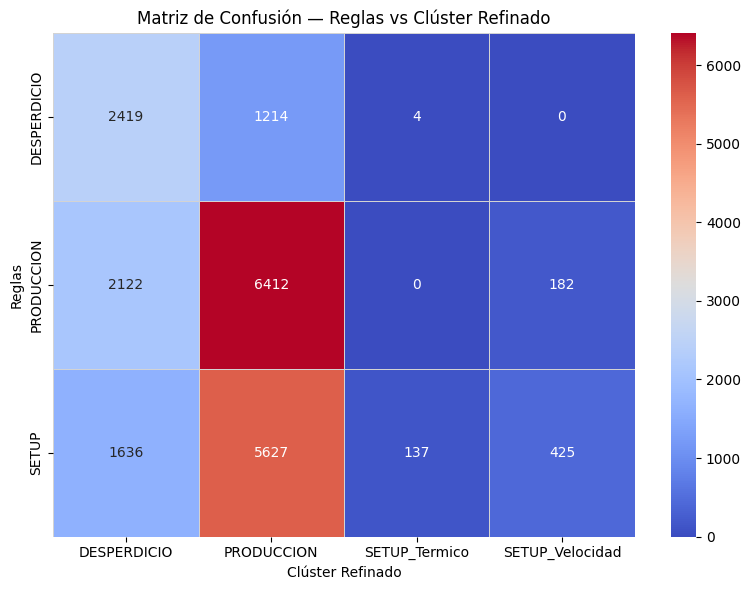


✅ Matriz de confusión y mapa de calor generados.


In [ ]:
# =========================================
# Matriz de confusión con estados refinados (k=4)
# Requisitos: timeline_cluster (con estado_cluster_refinado), out (con estado)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn para colores más suaves
from IPython.display import display

# ---------- 0) Validaciones ----------
for var in ["timeline_cluster", "out"]:
    if var not in globals():
        raise RuntimeError(f"Falta '{var}' en el entorno.")

if "estado_cluster_refinado" not in timeline_cluster.columns:
     raise RuntimeError("No encuentro 'estado_cluster_refinado' en 'timeline_cluster'. Ejecuta el Bloque 3.3.1. primero.")
if "estado" not in out.columns:
     raise RuntimeError("No encuentro 'estado' en 'out'. Ejecuta el Bloque 3.1. primero.")


# ---------- 1) Alinear los estados ----------
# Usamos el índice de timeline_cluster (que ya está a 1 min)
est_refinado = timeline_cluster["estado_cluster_refinado"]
est_regla = out["estado"].reindex(est_refinado.index)

# Eliminamos filas donde alguna etiqueta sea NaN
mask = est_refinado.notna() & est_regla.notna()
est_refinado = est_refinado[mask]
est_regla = est_regla[mask]

if len(est_refinado) == 0:
    print("⚠️ No hay suficientes filas con etiquetas en ambos esquemas para generar la matriz de confusión.")
else:
    # ---------- 2) Generar la matriz de confusión ----------
    conf_refined = pd.crosstab(est_regla, est_refinado, rownames=["Reglas"], colnames=["Clúster Refinado"], dropna=False)

    print("\n=== Matriz de confusión (Reglas vs Clúster Refinado) ===")
    display(conf_refined)

    # ---------- 3) Visualizar la matriz de confusión con colores suaves ----------
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_refined, annot=True, fmt="d", cmap="coolwarm", linewidths=.5, linecolor='lightgray') # Changed cmap to viridis
    plt.title("Matriz de Confusión — Reglas vs Clúster Refinado")
    plt.xlabel("Clúster Refinado")
    plt.ylabel("Reglas")
    plt.tight_layout()
    plt.show()

    print("\n✅ Matriz de confusión y mapa de calor generados.")

### 3.3.1. Nombrar sub-clústeres

In [ ]:
# =========================================
# Renombrado automático de SETUP en subestados
# Crea: timeline_cluster['cluster_id'], timeline_cluster['estado_cluster_refinado']
# =========================================
import numpy as np
import pandas as pd

# --- Validaciones mínimas (deben existir desde el Bloque 3C) ---
req = ["labels_km", "mapping", "mask_rows", "features", "use_cols", "timeline_cluster"]
for r in req:
    if r not in globals():
        raise RuntimeError(f"Falta '{r}'. Ejecuta primero el Bloque 3C.")

# 1) Reconstruir 'cluster_id' por timestamp (solo filas usadas en el clustering)
cluster_id = pd.Series(labels_km, index=mask_rows, name="cluster_id")
timeline_cluster = timeline_cluster.copy()
timeline_cluster.loc[cluster_id.index, "cluster_id"] = cluster_id.astype("Int64")  # conserva NA donde no hay

# 2) Medianas de características por clúster (usando exactamente las filas y columnas del clustering)
X_clust = features.loc[mask_rows, use_cols].copy()
cluster_medians = X_clust.assign(cluster=cluster_id.values).groupby("cluster").median()

# 3) Detectar clústeres cuyo nombre mayoritario (mapping) sea SETUP
#    mapping: dict cluster(int) -> nombre_estado (por mayoría contra reglas)
setup_clusters = [cl for cl, name in mapping.items() if name == "SETUP" and cl in cluster_medians.index]

# Si no hay duplicado de SETUP, solo creamos la columna "refinado" igual a la actual y salimos
timeline_cluster["estado_cluster_refinado"] = timeline_cluster.get("estado_cluster", pd.Series(index=timeline_cluster.index, dtype="object"))
if len(setup_clusters) <= 1:
    print("No hay múltiples clústeres mapeados a SETUP. No se aplican renombrados.")
else:
    # 4) Regla sencilla y explicable:
    #    - SETUP_Termico: mayor desviación térmica (cbz_dev_mean_5m) y menor velocidad (hal_speed_mean_5m)
    #    - SETUP_Velocidad: mayor variación/velocidad (hal_speed_std_5m y/o hal_speed_mean_5m)
    cols_present = set(cluster_medians.columns)

    has_dev = "cbz_dev_mean_5m" in cols_present
    has_vmean = "hal_speed_mean_5m" in cols_present
    has_vstd = "hal_speed_std_5m" in cols_present

    # Extrae métricas (NaN si no existen)
    med = cluster_medians.copy()
    if "cbz_dev_mean_5m" not in med.columns:
        med["cbz_dev_mean_5m"] = np.nan
    if "hal_speed_mean_5m" not in med.columns:
        med["hal_speed_mean_5m"] = np.nan
    if "hal_speed_std_5m" not in med.columns:
        med["hal_speed_std_5m"] = np.nan

    # Subtabla solo de clústeres SETUP
    s = med.loc[setup_clusters, ["cbz_dev_mean_5m", "hal_speed_mean_5m", "hal_speed_std_5m"]].copy()

    # Puntajes para decidir etiqueta:
    # - Térmico: más dev térmica y menor velocidad media
    # - Velocidad: mayor variación de velocidad y/o mayor velocidad media
    # Para evitar escalas distintas, usamos rankings dentro de los clústeres SETUP.
    # Cuanto menor el puntaje, más "térmico".
    s["rank_dev_desc"]  = (-s["cbz_dev_mean_5m"]).rank(method="first") if has_dev else 0
    s["rank_vmean_asc"] = ( s["hal_speed_mean_5m"]).rank(method="first") if has_vmean else 0
    s["termico_score"]  = s["rank_dev_desc"] + s["rank_vmean_asc"]

    # Para "velocidad", mayor variación y/o mayor velocidad media
    s["rank_vstd_desc"] = (-s["hal_speed_std_5m"]).rank(method="first") if has_vstd else 0
    s["rank_vmean_desc"]= (-s["hal_speed_mean_5m"]).rank(method="first") if has_vmean else 0
    s["velocidad_score"]= s["rank_vstd_desc"] + s["rank_vmean_desc"]

    # Etiquetado: el de menor termico_score => SETUP_Termico; el resto => SETUP_Velocidad
    # (si hay más de 2 SETUP, todos los demás van a Velocidad; ajusta si quieres más subestados)
    cl_termico = int(s["termico_score"].idxmin())
    cl_velocidad = [int(c) for c in s.index if c != cl_termico]

    # Construye un dict cluster->nuevo_nombre solo para los SETUP
    rename_dict = {cl_termico: "SETUP_Termico"}
    for cl in cl_velocidad:
        rename_dict[cl] = "SETUP_Velocidad"

    # 5) Aplicar renombrado solo donde estado_cluster actual sea SETUP (no tocamos otros estados)
    m = timeline_cluster["estado_cluster"].eq("SETUP") & timeline_cluster["cluster_id"].notna()
    idx_to_update = timeline_cluster.index[m]
    # Mapea por cluster_id (solo filas SETUP)
    timeline_cluster.loc[idx_to_update, "estado_cluster_refinado"] = [
        rename_dict.get(int(c), "SETUP") for c in timeline_cluster.loc[idx_to_update, "cluster_id"].astype(int)
    ]

    # 6) Resumen antes/después
    original = timeline_cluster["estado_cluster"].value_counts().rename("original")
    refinado  = timeline_cluster["estado_cluster_refinado"].value_counts().rename("refinado")
    resumen = pd.concat([original, refinado], axis=1).fillna(0).astype(int)

    print("Renombrado aplicado a clústeres SETUP:")
    print(" - SETUP_Termico  => cluster", cl_termico)
    if cl_velocidad:
        print(" - SETUP_Velocidad => clusters", cl_velocidad)
    print("\n=== Distribución antes vs. después ===")
    display(resumen)

# (Opcional) Persistir
# timeline_cluster[["cluster_id","estado_cluster","estado_cluster_refinado"]].to_csv("timeline_cluster_refinado.csv")


Renombrado aplicado a clústeres SETUP:
 - SETUP_Termico  => cluster 1
 - SETUP_Velocidad => clusters [3]

=== Distribución antes vs. después ===


,original,refinado
PRODUCCION,13253,13253
DESPERDICIO,6177,6177
SETUP,748,0
SETUP_Velocidad,0,607
SETUP_Termico,0,141


## **3.4 Reconciliación de estados (reglas vs clúster) y comparación de indicadores**

Velocidad nominal (reglas):  63.449999999999996
Velocidad nominal (clúster): 63.449999999999996

=== Indicadores por DÍA — Reglas (muestra) ===


,fecha,disponibilidad_regla,rendimiento_regla,calidad_regla,DESPERDICIO,PRODUCCION,SETUP
0,2024-03-19,1.0,0.986073,0.337838,245,125,80
1,2024-03-20,1.0,0.980358,0.680556,460,980,0
2,2024-03-21,1.0,0.975834,0.504861,713,727,0
3,2024-03-22,1.0,0.976635,0.291289,781,321,338
4,2024-03-23,1.0,0.977689,0.626168,440,737,263



=== Indicadores por DÍA — Clúster (muestra) ===


,fecha,disponibilidad_clust,rendimiento_clust,calidad_clust,DESPERDICIO,PRODUCCION,SETUP_Termico,SETUP_Velocidad
0,2024-03-19,1.0,0.986073,0.000000,370,0,8,69
1,2024-03-20,1.0,0.980358,0.000000,1440,0,0,0
2,2024-03-21,1.0,0.975834,0.000000,1440,0,0,0
3,2024-03-22,1.0,0.976635,0.410039,764,531,23,122
4,2024-03-23,1.0,0.977689,0.823488,248,1157,13,22



=== Comparación por DÍA (reglas vs clúster) ===


,fecha,disponibilidad_regla,rendimiento_regla,calidad_regla,disponibilidad_clust,rendimiento_clust,calidad_clust,diff_disponibilidad,diff_rendimiento,diff_calidad
0,2024-03-19,1.0,0.986073,0.337838,1.0,0.986073,0.000000,0.0,0.0,-0.337838
1,2024-03-20,1.0,0.980358,0.680556,1.0,0.980358,0.000000,0.0,0.0,-0.680556
2,2024-03-21,1.0,0.975834,0.504861,1.0,0.975834,0.000000,0.0,0.0,-0.504861
3,2024-03-22,1.0,0.976635,0.291289,1.0,0.976635,0.410039,0.0,0.0,0.118750
4,2024-03-23,1.0,0.977689,0.626168,1.0,0.977689,0.823488,0.0,0.0,0.197319


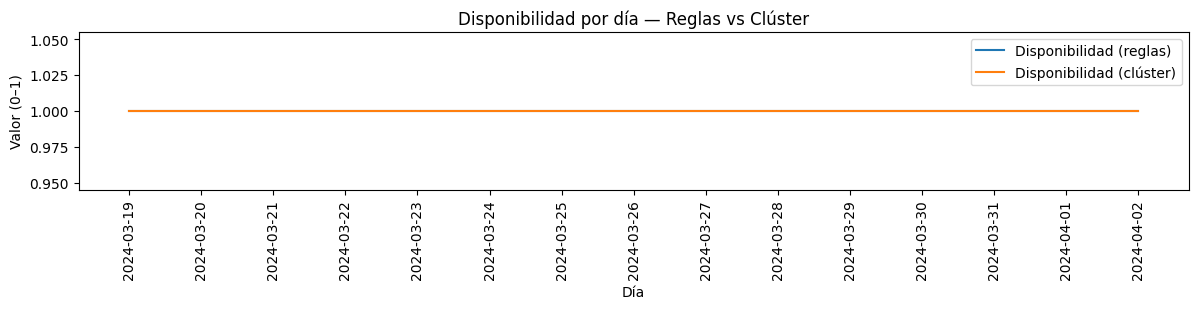

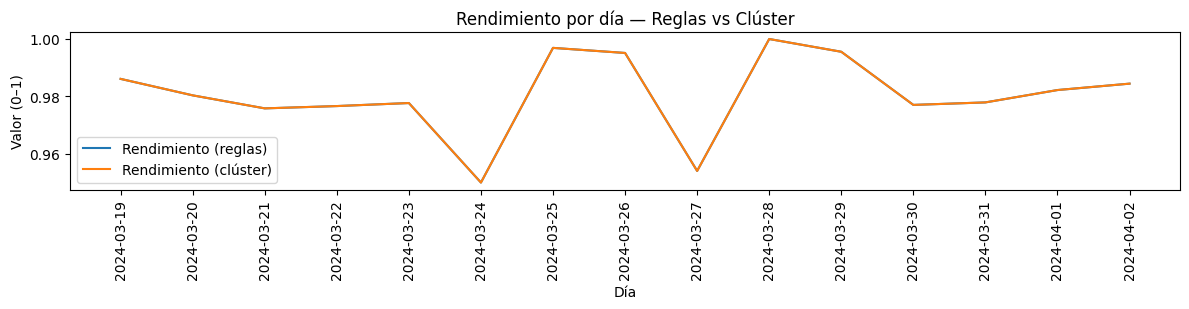

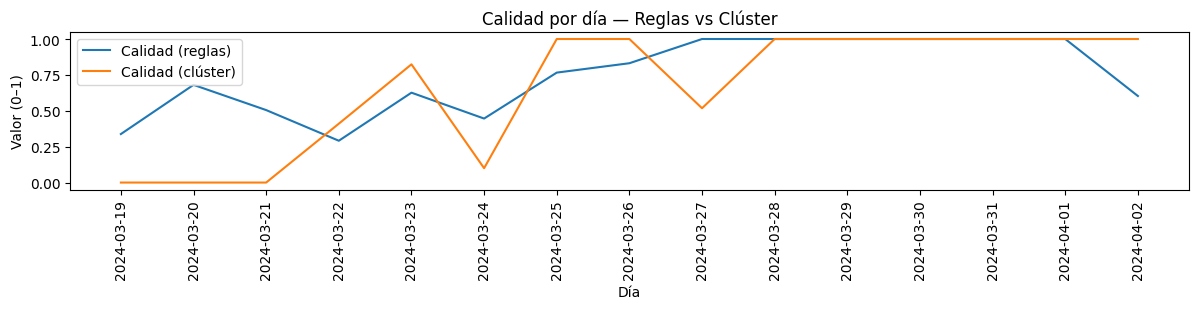

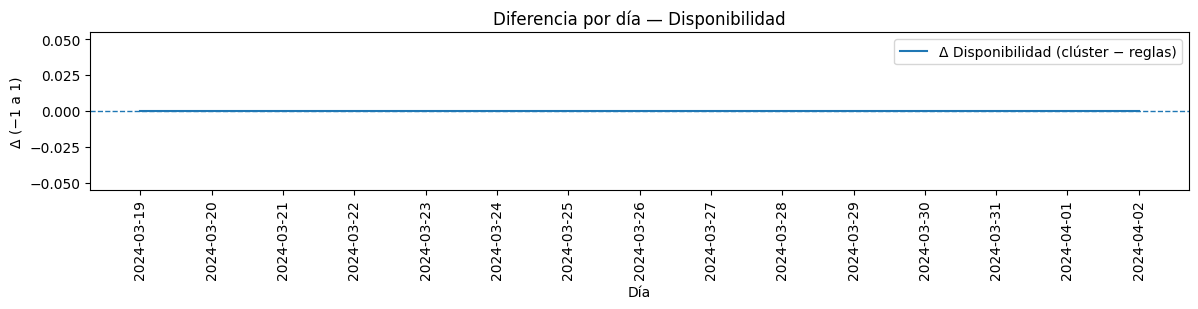

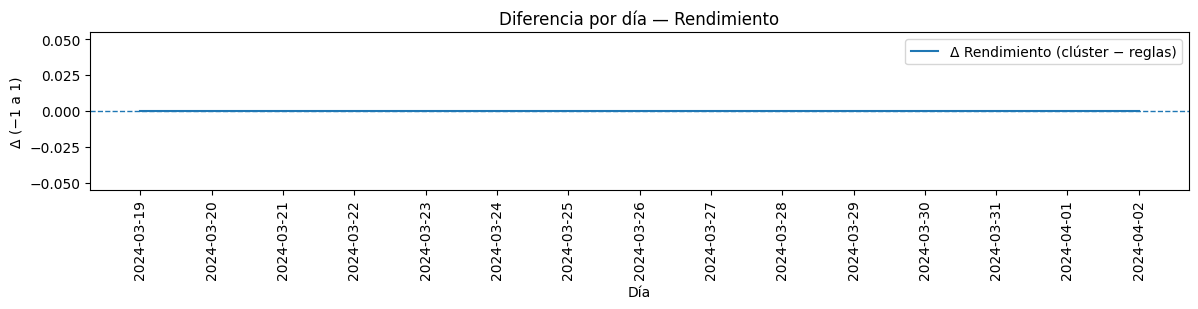

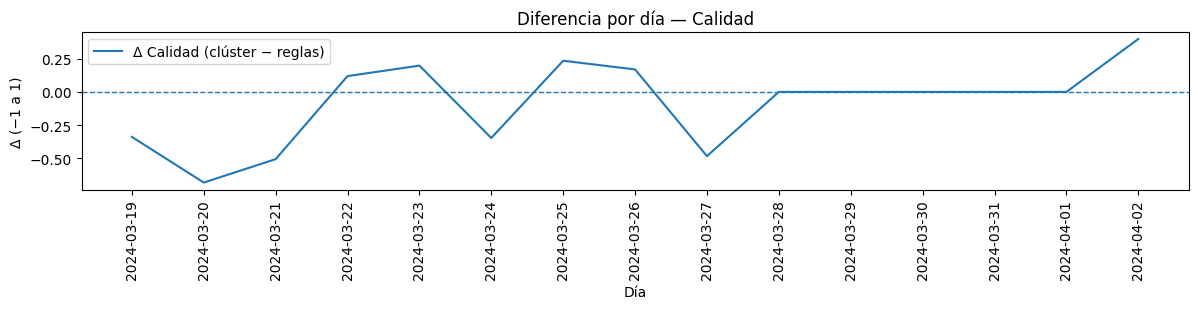


=== Matriz de confusión (reglas vs clúster) ===


clúster,DESPERDICIO,PRODUCCION,SETUP_Termico,SETUP_Velocidad
reglas,,,,
DESPERDICIO,2419,1214,4,0
PRODUCCION,2122,6412,0,182
SETUP,1636,5627,137,425


In [ ]:
# =========================================
# BLOQUE 3D (FIX) — Reglas vs Clúster: comparación robusta
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- 0) Validaciones ----------
for var in ["timeline", "out", "timeline_cluster", "TS_COL"]:
    if var not in globals():
        raise RuntimeError(f"Falta '{var}' en el entorno.")

must_features = {"hal_speed_mean_5m", "hal_speed_std_5m"}
if not must_features.issubset(set(timeline.columns)):
    raise RuntimeError("El 'timeline' no tiene las columnas de ventana requeridas (hal_speed_mean_5m, hal_speed_std_5m).")

# Elegir la columna de estado por clúster (refinada si existe)
ESTADO_CLUST_COL = "estado_cluster_refinado" if "estado_cluster_refinado" in timeline_cluster.columns else \
                   ("estado_cluster" if "estado_cluster" in timeline_cluster.columns else None)
if ESTADO_CLUST_COL is None:
    raise RuntimeError("No encuentro 'estado_cluster' ni 'estado_cluster_refinado' en 'timeline_cluster'.")

# ---------- 1) Construir un DataFrame base (índice alineado) ----------
base = pd.DataFrame(index=timeline.index)
base["hal_speed_mean_5m"] = timeline["hal_speed_mean_5m"]
base["hal_speed_std_5m"]  = timeline["hal_speed_std_5m"]
base["estado_regla"]      = out["estado"].reindex(base.index)
base["estado_clust"]      = timeline_cluster[ESTADO_CLUST_COL].reindex(base.index)
base.index.name = TS_COL
base["fecha"] = pd.to_datetime(base.index).date  # día calendario

# ---------- 2) Funciones utilitarias ----------
def _velocidad_nominal(df: pd.DataFrame, estado_col: str) -> float:
    """
    Estima velocidad nominal: p90 de hal_speed_mean_5m en PRODUCCION con variación baja (p25 de std).
    Si no hay PRODUCCION, usa p90 de velocidades >0.
    """
    # Filtra PRODUCCION
    prod = df[df[estado_col] == "PRODUCCION"]

    # Umbral de baja variación (p25 de std durante PRODUCCION)
    if prod["hal_speed_std_5m"].notna().any():
        var_p25 = prod["hal_speed_std_5m"].dropna().quantile(0.25)
    else:
        var_p25 = np.nan

    if not np.isnan(var_p25):
        base_v = prod.loc[prod["hal_speed_std_5m"] <= var_p25, "hal_speed_mean_5m"].dropna()
    else:
        base_v = df["hal_speed_mean_5m"].dropna()

    # Fallback si quedó vacío
    if len(base_v) == 0:
        base_v = df.loc[df["hal_speed_mean_5m"] > 0, "hal_speed_mean_5m"].dropna()
    if len(base_v) == 0:
        raise RuntimeError("No hay datos para estimar velocidad nominal.")

    vn = float(base_v.quantile(0.90))
    if vn <= 0:
        # red de seguridad
        positives = df.loc[df["hal_speed_mean_5m"] > 0, "hal_speed_mean_5m"]
        vn = float(max(positives.mean(), 1e-6))
    return vn

def _minute_metrics(df: pd.DataFrame, estado_col: str, vn: float, suffix: str) -> pd.DataFrame:
    """
    Crea métricas por minuto: disponibilidad, rendimiento, calidad (bueno/activo).
    Devuelve columnas con sufijo (_regla o _clust).
    """
    m = pd.DataFrame(index=df.index)
    m[f"disp_min_{suffix}"]   = (~df[estado_col].eq("PARO")).astype("float64")
    m[f"rend_min_{suffix}"]   = (df["hal_speed_mean_5m"] / vn).clip(lower=0, upper=1)
    m[f"activo_min_{suffix}"] = df[estado_col].isin(["PRODUCCION", "DESPERDICIO"]).astype("float64")
    m[f"cal_bueno_min_{suffix}"] = (df[estado_col].eq("PRODUCCION")).astype("float64")
    return m

def _agg_by_day(df: pd.DataFrame, estado_col: str, mm: pd.DataFrame, suffix: str) -> pd.DataFrame:
    """
    Agrega por día sin apply. Añade minutos por estado usando groupby.size().unstack().
    """
    tmp = pd.concat([df[[estado_col, "fecha"]], mm], axis=1)

    g = tmp.groupby("fecha", sort=True)
    day = pd.DataFrame({
        f"disponibilidad_{suffix}": g[f"disp_min_{suffix}"].mean(),
        f"rendimiento_{suffix}":    g[f"rend_min_{suffix}"].mean(),
        f"buenos_{suffix}":         g[f"cal_bueno_min_{suffix}"].sum(),
        f"activos_{suffix}":        g[f"activo_min_{suffix}"].sum()
    })
    day[f"calidad_{suffix}"] = np.where(day[f"activos_{suffix}"]>0,
                                        day[f"buenos_{suffix}"]/day[f"activos_{suffix}"], np.nan)

    # Minutos por estado/día
    estados_day = tmp.groupby(["fecha", estado_col]).size().unstack(fill_value=0)
    # Unir y ordenar columnas
    out_day = pd.concat([day.drop(columns=[f"buenos_{suffix}", f"activos_{suffix}"]), estados_day], axis=1).reset_index()
    return out_day

# ---------- 3) Velocidad nominal por esquema ----------
vn_regla = _velocidad_nominal(base, "estado_regla")
vn_clust = _velocidad_nominal(base, "estado_clust")
print("Velocidad nominal (reglas): ", vn_regla)
print("Velocidad nominal (clúster):", vn_clust)

# ---------- 4) Métricas por minuto ----------
mm_regla = _minute_metrics(base, "estado_regla", vn_regla, "regla")
mm_clust = _minute_metrics(base, "estado_clust", vn_clust, "clust")

# ---------- 5) Agregados por día ----------
por_dia_regla = _agg_by_day(base, "estado_regla", mm_regla, "regla")
por_dia_clust = _agg_by_day(base, "estado_clust", mm_clust, "clust")

print("\n=== Indicadores por DÍA — Reglas (muestra) ===")
display(por_dia_regla.head())
print("\n=== Indicadores por DÍA — Clúster (muestra) ===")
display(por_dia_clust.head())

# ---------- 6) Comparación por día ----------
cmp = pd.merge(por_dia_regla[["fecha","disponibilidad_regla","rendimiento_regla","calidad_regla"]],
               por_dia_clust[["fecha","disponibilidad_clust","rendimiento_clust","calidad_clust"]],
               on="fecha", how="inner")

for col in ["disponibilidad","rendimiento","calidad"]:
    cmp[f"diff_{col}"] = (cmp[f"{col}_clust"] - cmp[f"{col}_regla"])

print("\n=== Comparación por DÍA (reglas vs clúster) ===")
display(cmp.head())

# ---------- 7) Gráficas comparativas (X rotado 90°) ----------
x = cmp["fecha"].astype(str).to_list()
ROT = 90

plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["disponibilidad_regla"], label="Disponibilidad (reglas)")
plt.plot(x, cmp["disponibilidad_clust"], label="Disponibilidad (clúster)")
plt.title("Disponibilidad por día — Reglas vs Clúster")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["rendimiento_regla"], label="Rendimiento (reglas)")
plt.plot(x, cmp["rendimiento_clust"], label="Rendimiento (clúster)")
plt.title("Rendimiento por día — Reglas vs Clúster")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["calidad_regla"], label="Calidad (reglas)")
plt.plot(x, cmp["calidad_clust"], label="Calidad (clúster)")
plt.title("Calidad por día — Reglas vs Clúster")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()

# Diferencias
plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["diff_disponibilidad"], label="Δ Disponibilidad (clúster − reglas)")
plt.title("Diferencia por día — Disponibilidad")
plt.xlabel("Día"); plt.ylabel("Δ (−1 a 1)"); plt.xticks(rotation=ROT); plt.legend()
plt.axhline(0, linestyle="--", linewidth=1.0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["diff_rendimiento"], label="Δ Rendimiento (clúster − reglas)")
plt.title("Diferencia por día — Rendimiento")
plt.xlabel("Día"); plt.ylabel("Δ (−1 a 1)"); plt.xticks(rotation=ROT); plt.legend()
plt.axhline(0, linestyle="--", linewidth=1.0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 3.2))
plt.plot(x, cmp["diff_calidad"], label="Δ Calidad (clúster − reglas)")
plt.title("Diferencia por día — Calidad")
plt.xlabel("Día"); plt.ylabel("Δ (−1 a 1)"); plt.xticks(rotation=ROT); plt.legend()
plt.axhline(0, linestyle="--", linewidth=1.0)
plt.tight_layout(); plt.show()

# ---------- 8) Matriz de confusión global (minuto a minuto) ----------
mask_both = base["estado_regla"].notna() & base["estado_clust"].notna()
conf = pd.crosstab(base.loc[mask_both, "estado_regla"], base.loc[mask_both, "estado_clust"],
                   rownames=["reglas"], colnames=["clúster"])
print("\n=== Matriz de confusión (reglas vs clúster) ===")
display(conf)

# **4. Machine Learning: final**

## **4.1. Sensibilidad del tamaño de ventana**

=== Distribución de estados por tamaño de ventana ===


,conteo_w3,conteo_w5,conteo_w10
PRODUCCION,8911,8716,8395
SETUP,7523,7828,8181
DESPERDICIO,3747,3637,3605


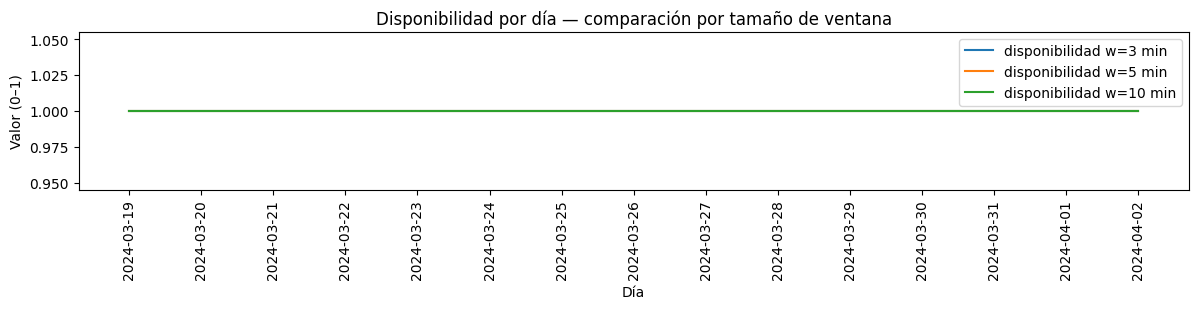

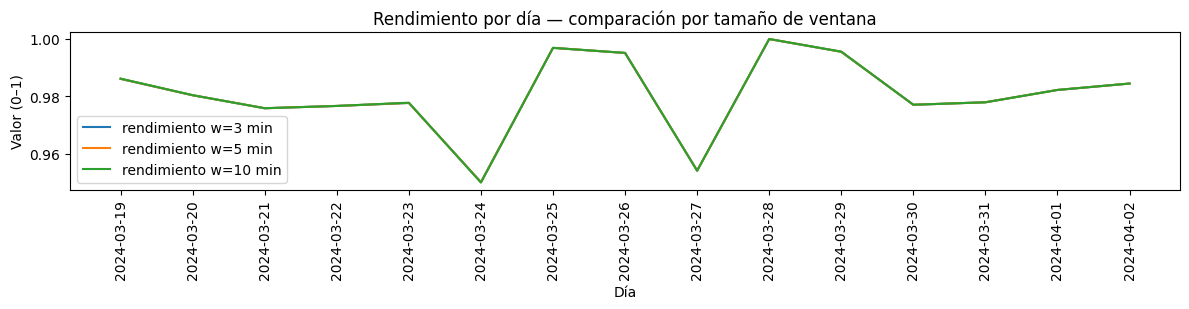

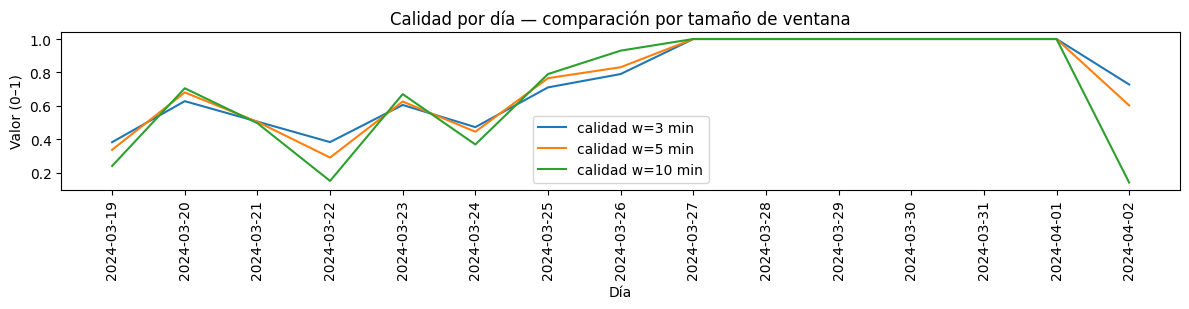

In [ ]:
# =========================================
# BLOQUE 4.1. — Sensibilidad a la ventana (3, 5, 10 min)
# Requisitos: df_1min, familias_1min, TS_COL
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# -------- 0) Validaciones --------
for name in ["df_1min", "familias_1min", "TS_COL"]:
    if name not in globals():
        raise RuntimeError(f"Falta '{name}'. Ejecuta Bloques 1–2.1 primero.")

HAL = familias_1min.get("haladores_vel", [])
RPM = familias_1min.get("rpm_modulos", [])
PRES= familias_1min.get("presion_modulos", [])
CBZ_SP = familias_1min.get("cabezal_SP", [])
CBZ_VP = familias_1min.get("cabezal_VP", [])

if not HAL:
    raise RuntimeError("No hay HAL*_VEL; son necesarios para etiquetar estados.")

# -------- 1) Utilidades sin deprecaciones --------
def _safe_mean(df: pd.DataFrame, cols: list) -> pd.Series:
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(index=df.index, dtype="float64")
    return df[cols].mean(axis=1)

def _build_features(df_1min: pd.DataFrame, window_min: int) -> pd.DataFrame:
    """Crea características con ventana deslizante window_min minutos (paso 1 min)."""
    W = f"{window_min}min"
    MINP = 3  # puntos mínimos dentro de la ventana

    hal_speed = _safe_mean(df_1min, HAL)
    rpm_level = _safe_mean(df_1min, RPM) if RPM else pd.Series(index=df_1min.index, dtype="float64")
    pres_level= _safe_mean(df_1min, PRES) if PRES else pd.Series(index=df_1min.index, dtype="float64")

    # |VP-SP| promediado entre zonas existentes
    if CBZ_SP and CBZ_VP:
        zones = []
        for sp in CBZ_SP:
            vp = sp.replace("_SP","_VP")
            if vp in df_1min.columns:
                zones.append((vp, sp))
        cbz_dev = (pd.concat([(df_1min[vp]-df_1min[sp]).abs() for vp,sp in zones], axis=1).mean(axis=1)) if zones else pd.Series(index=df_1min.index, dtype="float64")
    else:
        cbz_dev = pd.Series(index=df_1min.index, dtype="float64")

    def rmean(s): return s.rolling(window=W, min_periods=MINP).mean()
    def rstd(s):  return s.rolling(window=W, min_periods=MINP).std()

    def _rolling_mean_absdiff(df: pd.DataFrame, cols: list) -> pd.Series:
        cols = [c for c in cols if c in df.columns]
        if not cols:
            return pd.Series(index=df.index, dtype="float64")
        absdiff = df[cols].diff().abs().mean(axis=1)
        return absdiff.rolling(window=W, min_periods=MINP).mean()

    def _percent_zero_haladores(df: pd.DataFrame, hal_cols: list) -> pd.Series:
        hal_cols = [c for c in hal_cols if c in df.columns]
        zeros = df[hal_cols].eq(0).astype("float64")
        z_time = zeros.rolling(window=W, min_periods=MINP).mean()
        return z_time.mean(axis=1)

    feats = pd.DataFrame(index=df_1min.index)
    feats["hal_speed_mean"] = rmean(hal_speed)
    feats["hal_speed_std"]  = rstd(hal_speed)
    feats["hal_pct_zero"]   = _percent_zero_haladores(df_1min, HAL)

    if not rpm_level.empty:
        feats["rpm_level_mean"] = rmean(rpm_level)
        feats["rpm_var_t"]      = rstd(rpm_level)
        feats["rpm_absdiff"]    = _rolling_mean_absdiff(df_1min, RPM)

    if not pres_level.empty:
        feats["pres_level_mean"]= rmean(pres_level)
        feats["pres_var_t"]     = rstd(pres_level)

    if not cbz_dev.empty:
        feats["cbz_dev_mean"]   = rmean(cbz_dev)
        feats["cbz_dev_std"]    = rstd(cbz_dev)

    return feats

def _quantile(s: pd.Series, q: float, fallback=np.nan):
    s = s.dropna()
    return float(s.quantile(q)) if len(s)>0 else fallback

def _label_states(features: pd.DataFrame) -> pd.Series:
    """Reglas: PARO, PRODUCCION, DESPERDICIO, SETUP (idénticas a 2B, con cuantiles adaptativos)."""
    pos_hal = features["hal_speed_mean"][features["hal_speed_mean"]>0] if "hal_speed_mean" in features else pd.Series(dtype="float64")
    speed_active = _quantile(pos_hal, 0.10, 0.0)
    speed_paro   = 0.5 * speed_active
    pct_zero_hi  = 0.8  # 80% de ceros

    rpm_var_lo = _quantile(features.get("rpm_var_t", pd.Series(dtype="float64")), 0.25)
    rpm_var_hi = _quantile(features.get("rpm_var_t", pd.Series(dtype="float64")), 0.75)
    hal_var_lo = _quantile(features["hal_speed_std"], 0.25) if "hal_speed_std" in features else np.nan
    hal_var_hi = _quantile(features["hal_speed_std"], 0.75) if "hal_speed_std" in features else np.nan
    dev_mid    = _quantile(features.get("cbz_dev_mean", pd.Series(dtype="float64")), 0.50)
    dev_hi     = _quantile(features.get("cbz_dev_mean", pd.Series(dtype="float64")), 0.75)

    pres_med   = _quantile(features.get("pres_level_mean", pd.Series(dtype="float64")), 0.50)
    pres_high  = np.nanmax([300.0, pres_med]) if not np.isnan(pres_med) else np.nan

    is_paro = (
        (features["hal_speed_mean"] <= speed_paro) |
        (features["hal_pct_zero"] >= pct_zero_hi)
    )

    is_prod = (
        (features["hal_speed_mean"] >= speed_active) &
        ( (np.isnan(rpm_var_lo) or (features.get("rpm_var_t", pd.Series(index=features.index)) <= rpm_var_lo)) &
          (np.isnan(hal_var_lo) or (features["hal_speed_std"] <= hal_var_lo)) &
          (np.isnan(dev_mid)    or (features.get("cbz_dev_mean", pd.Series(index=features.index)) <= dev_mid)) ) &
        (np.isnan(pres_high) or (features.get("pres_level_mean", pd.Series(index=features.index)) >= 0))
    ) & (~is_paro)

    is_desp = (
        (features["hal_speed_mean"] >= speed_active) &
        ( ( (not np.isnan(rpm_var_hi)) and (features.get("rpm_var_t", pd.Series(index=features.index)) >= rpm_var_hi) ) |
          ( (not np.isnan(hal_var_hi)) and (features["hal_speed_std"] >= hal_var_hi) ) |
          ( (not np.isnan(dev_hi))     and (features.get("cbz_dev_mean", pd.Series(index=features.index)) >= dev_hi) ) ) &
        (np.isnan(pres_high) or (features.get("pres_level_mean", pd.Series(index=features.index)) >= pres_high))
    ) & (~is_paro) & (~is_prod)

    labels = pd.Series(index=features.index, dtype="object")
    labels.loc[is_paro] = "PARO"
    labels.loc[is_prod] = "PRODUCCION"
    labels.loc[is_desp] = "DESPERDICIO"
    labels.fillna("SETUP", inplace=True)
    return labels

def _agg_day_from(labels: pd.Series, hal_speed_mean: pd.Series) -> pd.DataFrame:
    """Indicadores por día y minutos por estado, dado un rotulado y la velocidad promedio."""
    df = pd.DataFrame({"estado": labels, "hal_speed_mean": hal_speed_mean})
    df.index.name = TS_COL
    df["disp_min"] = (~df["estado"].eq("PARO")).astype("float64")
    # Velocidad nominal (p90 de producción con variación baja dentro del propio esquema)
    # Para simplicidad aquí: p90 de hal_speed_mean > 0
    base = df.loc[df["hal_speed_mean"]>0, "hal_speed_mean"].dropna()
    if len(base)==0:
        base = df["hal_speed_mean"].dropna()
    vn = float(base.quantile(0.90)) if len(base)>0 else 1.0
    if vn <= 0: vn = 1.0
    df["rend_min"] = (df["hal_speed_mean"] / vn).clip(0,1)

    df["activo_min"] = df["estado"].isin(["PRODUCCION","DESPERDICIO"]).astype("float64")
    df["calidad_bueno_min"] = df["estado"].eq("PRODUCCION").astype("float64")

    df["fecha"] = df.index.date
    agg = df.groupby("fecha", sort=True).agg(
        disponibilidad=("disp_min","mean"),
        rendimiento=("rend_min","mean"),
        buenos=("calidad_bueno_min","sum"),
        activos=("activo_min","sum")
    )
    agg["calidad"] = np.where(agg["activos"]>0, agg["buenos"]/agg["activos"], np.nan)
    agg = agg.drop(columns=["buenos","activos"])

    min_est = pd.crosstab(df["fecha"], df["estado"]).reindex(agg.index, fill_value=0)
    return pd.concat([agg, min_est], axis=1).reset_index()

# -------- 2) Ejecutar para 3, 5 y 10 minutos --------
windows = [3, 5, 10]
results = {}

for w in windows:
    feats = _build_features(df_1min, w)
    labels = _label_states(feats)
    por_dia = _agg_day_from(labels, feats["hal_speed_mean"])
    dist = labels.value_counts().rename(f"conteo_w{w}")
    results[w] = {"features":feats, "labels":labels, "por_dia":por_dia, "dist":dist}

# -------- 3) Tabla comparativa de distribución de estados --------
dist_df = pd.concat([results[w]["dist"] for w in windows], axis=1).fillna(0).astype(int)
print("=== Distribución de estados por tamaño de ventana ===")
display(dist_df)

# -------- 4) Gráficas comparativas por día (ejemplo: disponibilidad) --------
ROT=90
plt.figure(figsize=(12,3.2))
for w in windows:
    pd.plotting.register_matplotlib_converters()
    x = results[w]["por_dia"]["fecha"].astype(str)
    y = results[w]["por_dia"]["disponibilidad"]
    plt.plot(x, y, label=f"disponibilidad w={w} min")
plt.title("Disponibilidad por día — comparación por tamaño de ventana")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3.2))
for w in windows:
    x = results[w]["por_dia"]["fecha"].astype(str)
    y = results[w]["por_dia"]["rendimiento"]
    plt.plot(x, y, label=f"rendimiento w={w} min")
plt.title("Rendimiento por día — comparación por tamaño de ventana")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3.2))
for w in windows:
    x = results[w]["por_dia"]["fecha"].astype(str)
    y = results[w]["por_dia"]["calidad"]
    plt.plot(x, y, label=f"calidad w={w} min")
plt.title("Calidad por día — comparación por tamaño de ventana")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)"); plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout(); plt.show()


## **4.2. Exploración de k (2–5) y selección**

=== Métricas por k ===


,clusters_distintos,silhouette,inercia,min_prop_cluster
k,,,,
2,2,0.859107,129713.088393,0.006988
3,3,0.305190,102003.047183,0.007037
4,4,0.333454,86428.355986,0.006988
5,5,0.252407,76533.353644,0.006938



Selección final de k: 5


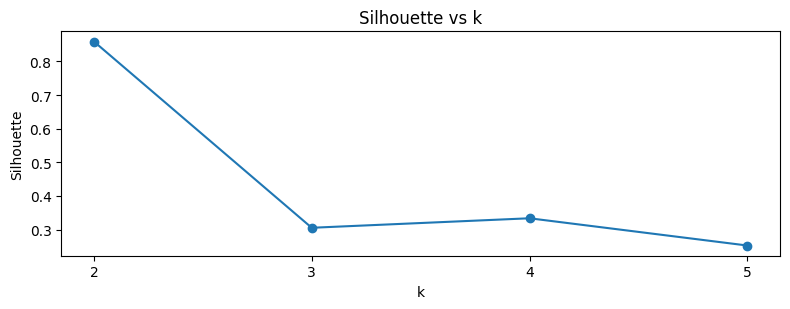

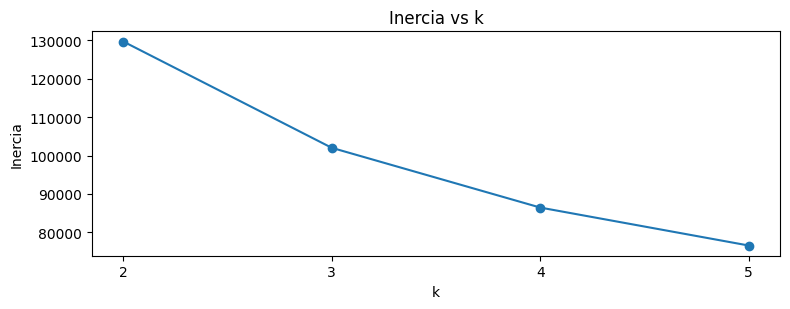


✅ BLOQUE 4.2. listo: k_report, k elegido y objetos para 4.3. disponibles.


In [ ]:
# =========================================
# BLOQUE 4.2. Barrido de k (2..5) con detección de nombres y selección robusta
# Requisitos: 'features' y 'out["estado"]' (para mapeos)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- 0) Validaciones ----------
if 'features' not in globals():
    if 'results' in globals() and 5 in results:
        features = results[5]["features"].copy()
    else:
        raise RuntimeError("No encuentro 'features'. Ejecutar bloques anteriores.")

# ---------- 1) Unificación de nombres de columnas ----------
# Dos esquemas posibles:
#   (A) 2.1/3.3: hal_speed_mean_5m, hal_speed_std_5m, rpm_level_mean_5m, ...
#   (B) 4.1:    hal_speed_mean,    hal_speed_std,    rpm_level_mean,    ...
# Este bloque detecta el esquema y crea un DataFrame con nombres "sin sufijo" para el clustering.

rename_map_5m_to_plain = {
    "hal_speed_mean_5m": "hal_speed_mean",
    "hal_speed_std_5m": "hal_speed_std",
    "rpm_level_mean_5m": "rpm_level_mean",
    "rpm_var_t_5m": "rpm_var_t",
    "rpm_absdiff_5m": "rpm_absdiff",
    "pres_level_mean_5m": "pres_level_mean",
    "pres_var_t_5m": "pres_var_t",
    "cbz_dev_mean_5m": "cbz_dev_mean",
    "cbz_dev_std_5m": "cbz_dev_std",
}

# Si detecto columnas *_5m, renombro a plano
cols = features.columns.tolist()
has_5m = any(c.endswith("_5m") for c in cols)
if has_5m:
    fbase = features.rename(columns=rename_map_5m_to_plain).copy()
else:
    fbase = features.copy()

# ---------- 2) Selección de columnas numéricas disponibles ----------
candidate_cols = [
    "hal_speed_mean","hal_speed_std",
    "rpm_level_mean","rpm_var_t","rpm_absdiff",
    "pres_level_mean","pres_var_t",
    "cbz_dev_mean","cbz_dev_std"
]
use_cols = [c for c in candidate_cols if c in fbase.columns]
if len(use_cols) < 2:
    raise RuntimeError(
        "Se requieren ≥2 características para clustering. "
        f"Encontradas: {use_cols}. Revisa que las features existan"
    )

# Tomamos solo filas completas en las columnas seleccionadas
X = fbase[use_cols].dropna()
n = len(X)
if n < 5:
    print(f"⚠️ Muy pocas filas completas para un barrido estable (n={n}). "
          "Aún así, intentaré con k hasta n.")

# ---------- 3) Escalado ----------
sc = StandardScaler()
Xz = sc.fit_transform(X)

# ---------- 4) Barrido de k y métricas ----------
k_list = [2,3,4,5]
k_list = [k for k in k_list if k <= n]  # k no puede exceder n

rows = []
labels_by_k = {}
models = {}

for k in k_list:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = km.fit_predict(Xz)
    uniq = np.unique(lab)
    inertia = float(km.inertia_) if hasattr(km, "inertia_") else np.nan

    # Calcular silhouette solo cuando tiene sentido
    sil = np.nan
    if len(uniq) > 1 and n > k:
        try:
            sil = float(silhouette_score(Xz, lab))
        except Exception:
            sil = np.nan

    # Tamaño relativo mínimo de clúster
    vc = pd.Series(lab).value_counts(normalize=True).sort_index()
    min_prop = float(vc.min()) if len(vc) else np.nan

    rows.append({
        "k": k,
        "clusters_distintos": int(len(uniq)),
        "silhouette": sil,
        "inercia": inertia,
        "min_prop_cluster": min_prop
    })
    labels_by_k[k] = lab
    models[k] = km

k_report = pd.DataFrame(rows).set_index("k").sort_index()
print("=== Métricas por k ===")
display(k_report)

# ---------- 5) Selección robusta con preferencia por k alto ----------
# Filtros:
#   (a) clusters_distintos == k (evita colapso)
#   (b) min_prop_cluster >= 0.05 (evita clúster diminuto)
valid = k_report[(k_report["clusters_distintos"] == k_report.index) &
                 (k_report["min_prop_cluster"] >= 0.05)].copy()

chosen_k = None
if not valid.empty:
    if valid["silhouette"].notna().any():
        best_s = valid["silhouette"].max()
        tol = 0.02  # tolerancia para considerar "cerca del mejor"
        near = valid[valid["silhouette"] >= (best_s - tol)]
        chosen_k = int(near.index.max())  # preferimos el k MÁS ALTO dentro de near
    else:
        chosen_k = int(valid.index.max())
else:
    # Relajamos el tamaño mínimo si nada pasó; esto evita romper con pocos datos
    relaxed = k_report[(k_report["clusters_distintos"] == k_report.index) &
                       (k_report["min_prop_cluster"] >= 0.02)]
    if not relaxed.empty:
        if relaxed["silhouette"].notna().any():
            best_s = relaxed["silhouette"].max()
            tol = 0.02
            near = relaxed[relaxed["silhouette"] >= (best_s - tol)]
            chosen_k = int(near.index.max())
        else:
            chosen_k = int(relaxed.index.max())

if chosen_k is None:
    # Último recurso: el mayor k que al menos tenga ≥2 clústeres distintos
    fallback = k_report[k_report["clusters_distintos"] >= 2]
    chosen_k = int(fallback.index.max()) if not fallback.empty else int(k_list[0])

print(f"\nSelección final de k: {chosen_k}")

# ---------- 6) Gráficas de silhouette e inercia ----------
ROT = 0
plt.figure(figsize=(8, 3.2))
plt.plot(k_report.index, k_report["silhouette"], marker="o")
plt.title("Silhouette vs k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.xticks(k_report.index, rotation=ROT)
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 3.2))
plt.plot(k_report.index, k_report["inercia"], marker="o")
plt.title("Inercia vs k")
plt.xlabel("k"); plt.ylabel("Inercia")
plt.xticks(k_report.index, rotation=ROT)
plt.tight_layout(); plt.show()

# ---------- 7) Variables de salida ----------
chosen_labels = labels_by_k[chosen_k]
chosen_model  = models[chosen_k]
X_for_pca     = Xz
idx_for_pca   = X.index

print("\n✅ BLOQUE 4.2. listo: k_report, k elegido y objetos para 4.3. disponibles.")


## **4.3. Trazar figuras de clústeres**

=== Tabla clúster (k=5) vs. estado (reglas) ===


estado,DESPERDICIO,PRODUCCION,SETUP
cluster,,,
0,2372,2039,1636
1,648,4185,2608
2,613,2310,3021
3,4,0,136
4,0,182,424


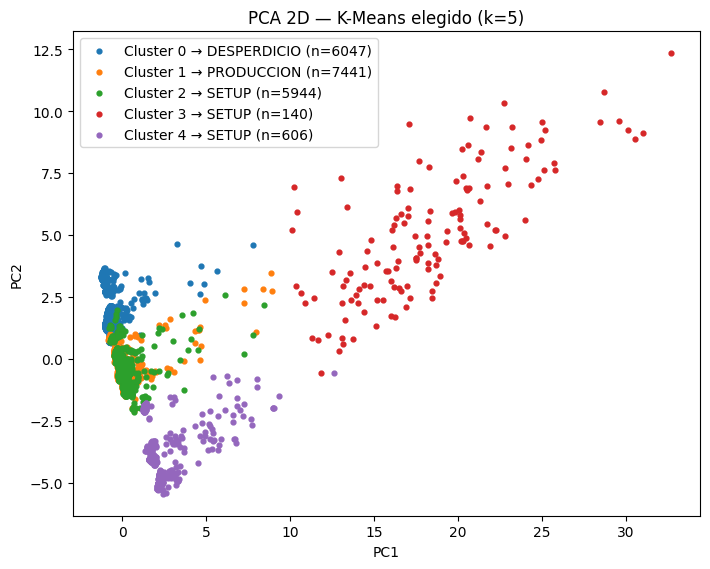

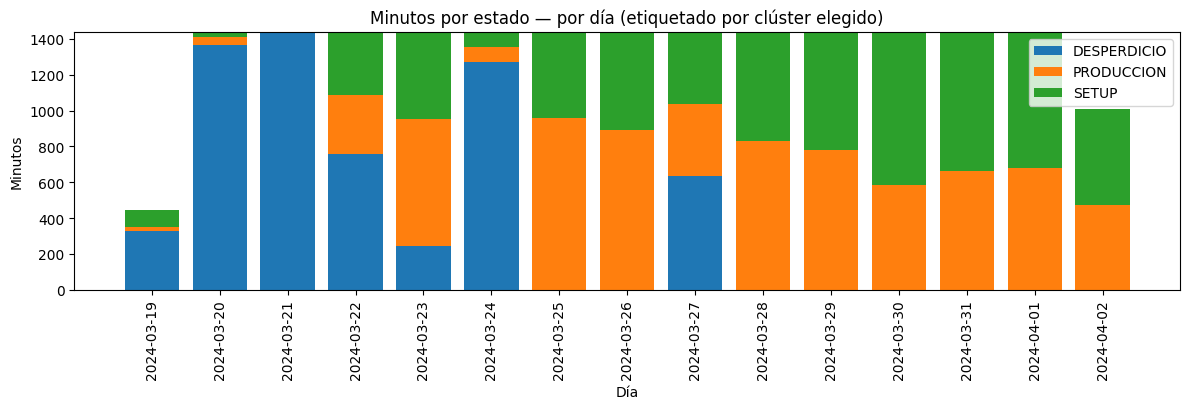

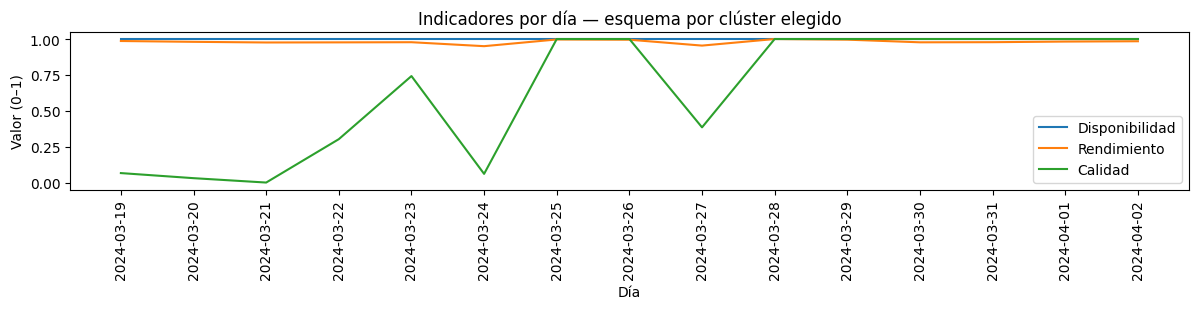


=== Matriz de confusión (reglas vs clúster elegido) ===


clúster,DESPERDICIO,PRODUCCION,SETUP
reglas,,,
DESPERDICIO,2372,648,617
PRODUCCION,2039,4185,2492
SETUP,1636,2608,3581


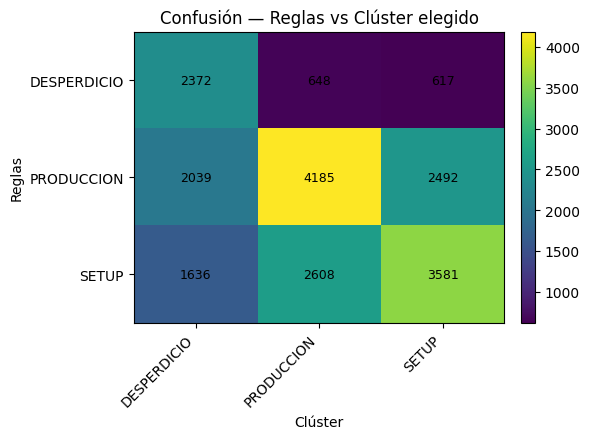


✅ BLOQUE 4.3. listo: figuras y tablas generadas con el k elegido


In [ ]:
# =========================================
# BLOQUE 4.3. — Figuras finales con el k elegido en 4.2.
# Requisitos: timeline, out (con columna 'estado'),
#             chosen_k, chosen_labels, idx_for_pca, X_for_pca (provenientes de 4.2.)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA

# ---------- 0) Validaciones y utilidades ----------
req = ["timeline","out","chosen_k","chosen_labels","idx_for_pca","X_for_pca"]
for r in req:
    if r not in globals():
        raise RuntimeError(f"Falta '{r}'. Ejecuta 3.1. y 4.2. antes de 4.3.")

def _ensure_dt_index(df, name_fallback="Timestamp"):
    """Asegura DatetimeIndex y orden; elimina filas con índice no parseable."""
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df[~df.index.isna()].sort_index()
    if df.index.name is None:
        df.index.name = name_fallback
    return df

timeline = _ensure_dt_index(timeline)
out = _ensure_dt_index(out, name_fallback=timeline.index.name or "Timestamp")

# Chequeos básicos
if "estado" not in out.columns:
    raise RuntimeError("En 'out' debe existir la columna 'estado' (etiquetas por reglas).")
if "hal_speed_mean_5m" not in timeline.columns:
    raise RuntimeError("En 'timeline' debe existir 'hal_speed_mean_5m' (viene de 2B).")
if "hal_speed_std_5m" not in timeline.columns:
    raise RuntimeError("En 'timeline' debe existir 'hal_speed_std_5m' (viene de 2B).")

# ---------- 1) Mapeo clúster → estado (por mayoría, versus reglas) ----------
# Alinea etiquetas de reglas al índice usado en 4.2.
y_rule = out["estado"].reindex(idx_for_pca)
mask_valid = y_rule.notna()
if mask_valid.sum() == 0:
    raise RuntimeError("No hay coincidencias entre 'idx_for_pca' y 'out[estado]' para calcular el mapeo.")

clusters_series = pd.Series(chosen_labels, index=idx_for_pca, name="cluster").loc[mask_valid]
y_rule_valid = y_rule.loc[mask_valid]

ct = pd.crosstab(clusters_series, y_rule_valid, dropna=False)
print(f"=== Tabla clúster (k={chosen_k}) vs. estado (reglas) ===")
display(ct)

# cluster -> estado mayoritario
mapping = ct.idxmax(axis=1).to_dict()

# Serie con el estado mapeado por clúster (solo en las filas usadas para clustering)
mapped_state = clusters_series.map(mapping).rename("estado_cluster_elegido")

# ---------- 2) PCA 2D con leyenda ----------
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_for_pca)

plt.figure(figsize=(7.2, 5.8))
for cl in sorted(np.unique(chosen_labels)):
    m = (chosen_labels == cl)
    etiqueta = f"Cluster {cl} → {mapping.get(cl,'—')} (n={int(m.sum())})"
    plt.scatter(X2[m, 0], X2[m, 1], s=12, label=etiqueta)
plt.title(f"PCA 2D — K-Means elegido (k={chosen_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
# plt.savefig("fig_pca_kmeans_final.png", dpi=200)
plt.show()

# ---------- 3) Construir el etiquetado final sobre toda la línea de tiempo ----------
# Partimos de un DataFrame con el índice completo de 'timeline'
timeline_cluster_final = pd.DataFrame(index=timeline.index)
# Solo asignamos donde hubo clustering (idx_for_pca); el resto quedará NaN
timeline_cluster_final.loc[mapped_state.index, "estado_cluster_final"] = mapped_state

# ---------- 4) Barras apiladas por día (minutos por estado con el esquema final) ----------
df_plot = timeline_cluster_final.copy()
df_plot["fecha"] = df_plot.index.date
min_est = pd.crosstab(df_plot["fecha"], df_plot["estado_cluster_final"]).sort_index()

ROT = 90
plt.figure(figsize=(12, 4.2))
bottom = np.zeros(len(min_est))
for col in min_est.columns:
    vals = min_est[col].to_numpy()
    plt.bar(min_est.index.astype(str), vals, bottom=bottom, label=col)
    bottom = bottom + vals
plt.title("Minutos por estado — por día (etiquetado por clúster elegido)")
plt.xlabel("Día"); plt.ylabel("Minutos")
plt.xticks(rotation=ROT); plt.legend()
plt.tight_layout()
# plt.savefig("fig_barras_estado_por_dia_final.png", dpi=200)
plt.show()

# ---------- 5) Indicadores por día (disponibilidad, rendimiento, calidad) ----------
def _agg_indicadores_por_dia(labels_series: pd.Series) -> pd.DataFrame:
    # Une métricas necesarias de timeline
    tmp = pd.concat(
        [timeline[["hal_speed_mean_5m","hal_speed_std_5m"]],
         labels_series.rename("estado")],
        axis=1
    )
    # Estima velocidad nominal:
    std_prod = tmp.loc[tmp["estado"].eq("PRODUCCION"), "hal_speed_std_5m"].dropna()
    var_p25 = std_prod.quantile(0.25) if len(std_prod) > 0 else np.nan
    if np.isnan(var_p25):
        base = tmp["hal_speed_mean_5m"].dropna()
    else:
        base = tmp.loc[tmp["estado"].eq("PRODUCCION") & (tmp["hal_speed_std_5m"] <= var_p25),
                       "hal_speed_mean_5m"].dropna()
    if len(base) == 0:
        base = tmp.loc[tmp["hal_speed_mean_5m"] > 0, "hal_speed_mean_5m"].dropna()
    vn = float(base.quantile(0.90)) if len(base) > 0 else 1.0
    if vn <= 0:
        vn = 1.0

    mm = pd.DataFrame(index=tmp.index)
    mm["disp_min"] = (~tmp["estado"].eq("PARO")).astype("float64")
    mm["rend_min"] = (tmp["hal_speed_mean_5m"]/vn).clip(0,1)
    mm["activo_min"] = tmp["estado"].isin(["PRODUCCION","DESPERDICIO"]).astype("float64")
    mm["calidad_bueno_min"] = tmp["estado"].eq("PRODUCCION").astype("float64")
    mm["fecha"] = mm.index.date

    agg = mm.groupby("fecha", sort=True).agg(
        disponibilidad=("disp_min","mean"),
        rendimiento=("rend_min","mean"),
        buenos=("calidad_bueno_min","sum"),
        activos=("activo_min","sum")
    )
    agg["calidad"] = np.where(agg["activos"]>0, agg["buenos"]/agg["activos"], np.nan)
    agg = agg.drop(columns=["buenos","activos"]).reset_index()
    return agg

por_dia_final = _agg_indicadores_por_dia(timeline_cluster_final["estado_cluster_final"])

x = por_dia_final["fecha"].astype(str)
plt.figure(figsize=(12, 3.2))
plt.plot(x, por_dia_final["disponibilidad"], label="Disponibilidad")
plt.plot(x, por_dia_final["rendimiento"],   label="Rendimiento")
plt.plot(x, por_dia_final["calidad"],       label="Calidad")
plt.title("Indicadores por día — esquema por clúster elegido")
plt.xlabel("Día"); plt.ylabel("Valor (0–1)")
plt.xticks(rotation=ROT); plt.legend(); plt.tight_layout()
# plt.savefig("fig_indicadores_por_dia_final.png", dpi=200)
plt.show()

# ---------- 6) Matriz de confusión (reglas vs clúster elegido) ----------
est_rule = out["estado"].reindex(timeline.index)
est_clust = timeline_cluster_final["estado_cluster_final"].reindex(timeline.index)
mask = est_rule.notna() & est_clust.notna()
conf = pd.crosstab(est_rule[mask], est_clust[mask], rownames=["reglas"], colnames=["clúster"])
print("\n=== Matriz de confusión (reglas vs clúster elegido) ===")
display(conf)

# Mapa de calor simple
plt.figure(figsize=(6, 4.5))
im = plt.imshow(conf.to_numpy(), aspect="auto")
plt.title("Confusión — Reglas vs Clúster elegido")
plt.xlabel("Clúster"); plt.ylabel("Reglas")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=range(conf.shape[1]), labels=list(conf.columns), rotation=45, ha="right")
plt.yticks(ticks=range(conf.shape[0]), labels=list(conf.index))
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, str(conf.iat[i, j]), ha="center", va="center", fontsize=9)
plt.tight_layout()
# plt.savefig("fig_confusion_final.png", dpi=200)
plt.show()

print("\n✅ BLOQUE 4.3. listo: figuras y tablas generadas con el k elegido")
# (Opcional) Guardados:
# por_dia_final.to_csv("indicadores_por_dia_cluster_final.csv", index=False)
# timeline_cluster_final["estado_cluster_final"].to_csv("estados_cluster_final_minuto_a_minuto.csv")
# ct.to_csv("tabla_cluster_vs_reglas_k_elegido.csv")


# **Deep Clustering**

Modelo Autoencoder definido: 9 -> 4 -> 9

Entrenando Autoencoder...
Entrenamiento completado.


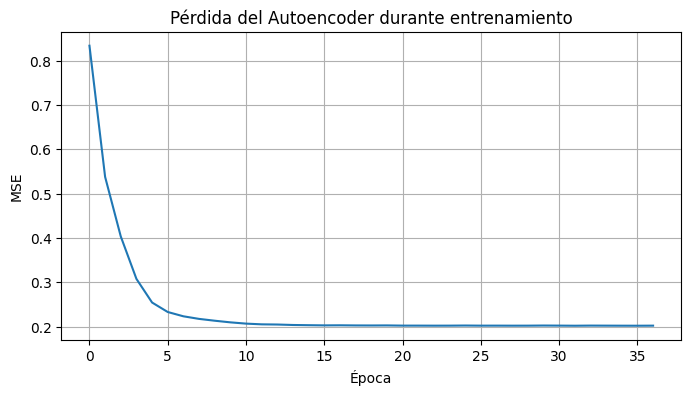

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Datos codificados a 4 dimensiones. Forma: (20178, 4)

Usando k=5 (elegido en Bloque 4.2.) para K-Means en espacio latente.

K-Means aplicado en el espacio latente. Etiquetas generadas para 20178 muestras.

=== Tabla clúster (Deep Clustering) vs. estado (reglas) ===


estado,DESPERDICIO,PRODUCCION,SETUP
cluster_deep,,,
0,652,4579,1920
1,4,0,137
2,2417,2101,1609
3,556,1853,3712
4,8,183,447



Mapeo clúster (Deep) -> estado (reglas por mayoría):
{0: 'PRODUCCION', 1: 'SETUP', 2: 'DESPERDICIO', 3: 'SETUP', 4: 'SETUP'}

=== Matriz de confusión (reglas vs clúster profundo mapeado) ===


clúster_deep,DESPERDICIO,PRODUCCION,SETUP
reglas,,,
DESPERDICIO,2417,652,568
PRODUCCION,2101,4579,2036
SETUP,1609,1920,4296


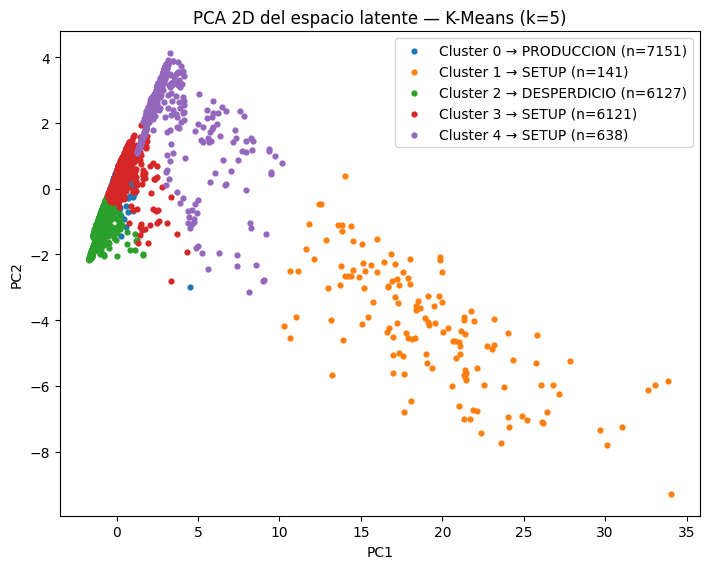


✅ Etiquetas de Deep Clustering (IDs y mapeadas) añadidas a 'timeline_cluster_final'.


,estado_cluster_final,cluster_deep_id,estado_deep_cluster_mapeado
Timestamp,,,
2024-03-19 16:30:00,NaN,<NA>,NaN
2024-03-19 16:31:00,NaN,<NA>,NaN
2024-03-19 16:32:00,NaN,<NA>,NaN
2024-03-19 16:33:00,SETUP,4,SETUP
2024-03-19 16:34:00,SETUP,4,SETUP


In [ ]:
# =========================================
# Deep Clustering (Autoencoder)
# Requisitos: Xz (datos escalados de 4.2.)
# =========================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- 0) Validaciones ----------
if 'Xz' not in globals() or 'idx_for_pca' not in globals():
    raise RuntimeError("Faltan 'Xz' o 'idx_for_pca'. Ejecuta Bloque 4.2. primero.")

n_features = Xz.shape[1]
n_samples = Xz.shape[0]

if n_samples < 10:
    print(f"⚠️ Muy pocos datos para entrenar una red neuronal (n={n_samples}). Se omite el entrenamiento.")

else:
    # ---------- 1) Definir el modelo Autoencoder simple ----------
    # Un autoencoder intenta reconstruir su entrada, aprendiendo una representación
    # de menor dimensión en la capa intermedia (bottleneck).
    encoding_dim = max(2, n_features // 2) # Dimensión de la capa intermedia (mínimo 2)

    input_layer = Input(shape=(n_features,))
    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    # Decoder
    decoded = Dense(n_features, activation='linear')(encoded) # Linear para reconstruir rangos escalados

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Compilar el modelo
    autoencoder.compile(optimizer='adam', loss='mse') # MSE es común para reconstrucción

    print(f"Modelo Autoencoder definido: {n_features} -> {encoding_dim} -> {n_features}")

    # ---------- 2) Entrenar el modelo ----------
    # Usamos EarlyStopping para evitar sobreajuste y detener el entrenamiento
    # cuando la pérdida en validación deja de mejorar.
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    print("\nEntrenando Autoencoder...")
    history = autoencoder.fit(
        Xz, Xz, # La entrada es también la salida (autoencoder)
        epochs=100, # Máximo de épocas
        batch_size=32,
        shuffle=True,
        callbacks=[early_stop],
        verbose=0 # No imprimir cada época
    )
    print("Entrenamiento completado.")

    # Gráfica de la pérdida
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.title('Pérdida del Autoencoder durante entrenamiento')
    plt.xlabel('Época'); plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

    # ---------- 3) Obtener la representación latente (embedding) ----------
    # Creamos un nuevo modelo que es solo el encoder
    encoder_model = Model(inputs=input_layer, outputs=encoded)
    X_encoded = encoder_model.predict(Xz)

    print(f"\nDatos codificados a {encoding_dim} dimensiones. Forma: {X_encoded.shape}")

    # ---------- 4) Aplicar K-Means sobre la representación latente ----------
    # Esto combina la reducción de dimensionalidad del autoencoder con el clustering de K-Means.
    # Usaremos el mismo número de clústeres que se eligió en el Bloque 4.2 si existe,
    # de lo contrario, usaremos 4 por defecto.
    if 'chosen_k' in globals():
        n_clusters_final = chosen_k
        print(f"\nUsando k={n_clusters_final} (elegido en Bloque 4.2.) para K-Means en espacio latente.")
    else:
        n_clusters_final = 4
        print(f"\nUsando k={n_clusters_final} por defecto para K-Means en espacio latente.")


    if n_samples < n_clusters_final:
         print(f"⚠️ Número de muestras ({n_samples}) menor que número de clústeres ({n_clusters_final}). Se omite K-Means.")
    else:
        kmeans_deep = KMeans(n_clusters=n_clusters_final, n_init=10, random_state=42)
        labels_deep = kmeans_deep.fit_predict(X_encoded)

        print(f"\nK-Means aplicado en el espacio latente. Etiquetas generadas para {len(labels_deep)} muestras.")

        # ---------- 5) Mapeo clúster → estado (por mayoría, versus reglas) ----------
        # Alinea etiquetas de reglas al índice usado para el clustering profundo
        if 'out' in globals() and 'estado' in out.columns:
             # Asegurar que 'out' tiene DatetimeIndex para reindex
            if not isinstance(out.index, pd.DatetimeIndex):
                out_dt = out.copy()
                out_dt.index = pd.to_datetime(out_dt.index, errors='coerce')
                out_dt = out_dt[~out_dt.index.isna()].sort_index()
            else:
                out_dt = out
            y_rule_deep = out_dt["estado"].reindex(idx_for_pca)
            mask_valid_deep = y_rule_deep.notna()

            if mask_valid_deep.sum() > 0:
                clusters_series_deep = pd.Series(labels_deep, index=idx_for_pca, name="cluster_deep").loc[mask_valid_deep]
                y_rule_deep_valid = y_rule_deep.loc[mask_valid_deep]

                ct_deep = pd.crosstab(clusters_series_deep, y_rule_deep_valid, dropna=False)
                print(f"\n=== Tabla clúster (Deep Clustering) vs. estado (reglas) ===")
                display(ct_deep)

                # cluster -> estado mayoritario
                mapping_deep = ct_deep.idxmax(axis=1).to_dict()
                print("\nMapeo clúster (Deep) -> estado (reglas por mayoría):")
                print(mapping_deep)

                # Serie con el estado mapeado por clúster (solo en las filas usadas)
                mapped_state_deep = clusters_series_deep.map(mapping_deep).rename("estado_deep_cluster")

                # Matriz de confusión (Reglas vs Deep Cluster Mapeado)
                conf_deep = pd.crosstab(y_rule_deep_valid, mapped_state_deep, rownames=["reglas"], colnames=["clúster_deep"])
                print("\n=== Matriz de confusión (reglas vs clúster profundo mapeado) ===")
                display(conf_deep)

                # Gráfica PCA 2D del espacio latente con etiquetas mapeadas
                if encoding_dim >= 2:
                    # Si encoding_dim es 2, usamos X_encoded directamente
                    if encoding_dim == 2:
                         X_plot = X_encoded[mask_valid_deep.values, :]
                    # Si es > 2, aplicamos PCA a X_encoded
                    else:
                        pca_deep = PCA(n_components=2, random_state=42)
                        X_plot = pca_deep.fit_transform(X_encoded[mask_valid_deep.values, :])


                    plt.figure(figsize=(7.2, 5.8))
                    for cl in sorted(np.unique(clusters_series_deep)):
                        m = (clusters_series_deep == cl)
                        etiqueta = f"Cluster {cl} → {mapping_deep.get(cl,'—')} (n={int(m.sum())})"
                        plt.scatter(X_plot[m.values, 0], X_plot[m.values, 1], s=12, label=etiqueta)

                    plt.title(f"PCA 2D del espacio latente — K-Means (k={n_clusters_final})")
                    plt.xlabel("PC1"); plt.ylabel("PC2")
                    plt.legend(loc="best", frameon=True)
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"\n⚠️ encoding_dim ({encoding_dim}) < 2. No se puede generar gráfica PCA 2D.")

            else:
                print("\n⚠️ No hay suficientes coincidencias entre el índice de los datos codificados y 'out[estado]' para calcular el mapeo y la confusión.")

        else:
            print("\n⚠️ No se encontró 'out' o la columna 'estado'. No se puede mapear clústeres a estados de reglas.")

        # ---------- 6) Adjuntar etiquetas al timeline (opcional) ----------
        # Crea una serie con las etiquetas del deep clustering alineada al índice original
        labels_deep_full_index = pd.Series(labels_deep, index=idx_for_pca, name="cluster_deep_id").reindex(timeline.index)

        # Si timeline_cluster_final existe, añade la columna
        if 'timeline_cluster_final' in globals():
            timeline_cluster_final["cluster_deep_id"] = labels_deep_full_index.astype("Int64") # Usa Int64 para permitir NA
            if 'mapping_deep' in globals():
                 timeline_cluster_final["estado_deep_cluster_mapeado"] = timeline_cluster_final["cluster_deep_id"].map(mapping_deep)
            print("\n✅ Etiquetas de Deep Clustering (IDs y mapeadas) añadidas a 'timeline_cluster_final'.")
            display(timeline_cluster_final.head())
        else:
            print("\n⚠️ 'timeline_cluster_final' no existe. No se adjuntaron las etiquetas del deep clustering.")